# COMP3010J Machine Learning Project —— Job Change
### 20205711 ZHANG Hanchu

# Step0: Background and problem statement
 Background: A company specializing in Big Data and Data Science is looking to recruit data scientists who have successfully completed their training courses. Numerous individuals have signed up for the training. The company aims to identify candidates genuinely interested in joining the company post-training, as opposed to those seeking new employment opportunities. This distinction is crucial for reducing recruitment costs and time, improving training quality, as well as planning course structures and categorizing candidates. Demographic, educational, and experiential information related to candidate sign-ups and enrollments is available. The dataset is designed to understand the factors leading individuals to leave their current jobs.

Problem Statement:
Predict the probability of a candidate will work for the company
Interpret model(s) such a way that illustrate which features affect candidate decision

# Step1: Get a general idea the structure of the data file
## a. See the label and variable type of the data file

In [1]:
# import the library to modify and visualize data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# the library that used to train model
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import RocCurveDisplay

# load the data-science-job-change.csv file
df = pd.read_csv("data-science-job-change.csv")

In [2]:
# show the detail of dataset
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

enrollee_id      city  city_development_index gender  \
0         8949  city_103                   0.920   Male   
1        29725   city_40                   0.776   Male   
2        11561   city_21                   0.624    NaN   
3        33241  city_115                   0.789    NaN   
4          666  city_162                   0.767   Male   

       relevent_experience enrolled_university education_level  \
0  Has relevent experience       no_enrollment        Graduate   
1   No relevent experience       no_enrollment        Graduate   
2   No relevent experience    Full time course        Graduate   
3   No relevent experience                 NaN        Graduate   
4  Has relevent experience       no_enrollment         Masters   

  major_discipline experience company_size    company_type last_new_job  \
0             STEM        >20          NaN             NaN            1   
1             STEM         15        50-99         Pvt Ltd           >4   
2             STEM          5          NaN             NaN        never   
3  Business Degree         <1          NaN         Pvt Ltd        never   
4             STEM        >20        50-99  Funded Startup            4   

   training_hours  target  
0              36     1.0  
1              47     0.0  
2              83     0.0  
3              52     1.0  
4               8     0.0

The data has the following feature:
 0   enrollee_id             unique, so we need to delete it later
 1   city                    city code, eg. "city_146"
 2   city_development_index  city development parameter  float64
 3   gender                  Male, Female, Other or NaN
 4   relevant_experience     Years of the experience
 5   enrolled_university     type of university NaN
 6   education_level         education level NaN
 7   major_discipline        Education major discipline of candidate NaN
 8   experience              Candidate total experience in years NaN
 9   company_size            Amount of employees in current employer's company NaN
 10  company_type            Type of current employer NaN
 11  last_new_job            Difference in years between previous job and current job NaN
 12  training_hours          training hours
 13  target                  1.0 (for job) or 0.0 (not for job)

## b. There has non-null variables

By observation, we can deduce the names and types of each label. It is evident that there are a total of 19,158 records. However, for certain labels, the count of non-null entries is less than this total. For instance, in the case of 'gender', there are only 14,650 non-null entries. This signifies the necessity to consider and address this issue while training the model. By observing the first five records, it's also apparent that the second and third entries lack gender records.

# Step 2: Data Analysis

## a. Delete useless column
It is obvious that the enrollee_id is unique, so it will not have contribution to the training, it is not a descriptive feature, so we just drop it.

In [3]:
del df['enrollee_id']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    19158 non-null  object 
 1   city_development_index  19158 non-null  float64
 2   gender                  14650 non-null  object 
 3   relevent_experience     19158 non-null  object 
 4   enrolled_university     18772 non-null  object 
 5   education_level         18698 non-null  object 
 6   major_discipline        16345 non-null  object 
 7   experience              19093 non-null  object 
 8   company_size            13220 non-null  object 
 9   company_type            13018 non-null  object 
 10  last_new_job            18735 non-null  object 
 11  training_hours          19158 non-null  int64  
 12  target                  19158 non-null  float64
dtypes: float64(2), int64(1), object(10)
memory usage: 1.9+ MB


## b. Transfer target type as boolean and convert to object

 For our target, we only have 2 float value, 1.0 and 0.0, so we can change it to integer, it is convenient to our visualization and predict.

In [4]:
df['target'] = df['target'].astype(int)
df["target"].value_counts()

target
0    14381
1     4777
Name: count, dtype: int64

## c. Merge the values of categories

#### Something wrong with the city, it has 123 unique category, we need to merge some of them, let's take a look at the graph

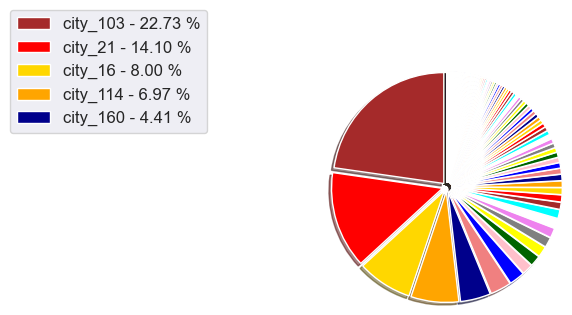

In [5]:
fig = plt.figure(figsize=(9, 3))
size_value_counts = df['city'].value_counts()
x = np.char.array([str(i) for i in size_value_counts.index])
y = np.array(size_value_counts.values)
colors = ['brown', 'red', 'gold', 'orange', 'darkblue', 'lightcoral', 'blue', 'pink', 'darkgreen', 'yellow', 'grey',
          'violet', 'white', 'cyan'][:len(size_value_counts.index)]
explode = [0.05] * len(size_value_counts.index)
percentage = 100. * y / y.sum()
patches, texts = plt.pie(y, colors=colors, startangle=90, radius=1.2, shadow=True,
                         wedgeprops={'linewidth': 1, 'linestyle': 'solid', 'antialiased': True}, explode=explode)
labels = ['{0} - {1:1.2f} %'.format(i, j) for i, j in zip(x, percentage)]
sort_legend = True
if sort_legend:
    patches, labels, dummy = zip(*sorted(zip(patches, labels, y), key=lambda x: x[2], reverse=True))
plt.legend(patches[:5], labels[:5], loc='center right', bbox_to_anchor=(-0.5, 1.), fontsize=12)

In [6]:
df['city'].value_counts()

city
city_103    4355
city_21     2702
city_16     1533
city_114    1336
city_160     845
            ... 
city_129       3
city_111       3
city_121       3
city_140       1
city_171       1
Name: count, Length: 123, dtype: int64

We can keep city_103, city_21, city_16, city_114 and city_160, because they have a large amount in the data set, and merge other type and name it as city_other.

In [7]:
df['city'] = df['city'].apply(lambda
                                  x: "city_others" if x != 'city_103' and x != 'city_21' and x != 'city_16' and x != 'city_114' and x != 'city_160' else x).astype(
    str)

In [8]:
df['city'].value_counts()

city
city_others    8387
city_103       4355
city_21        2702
city_16        1533
city_114       1336
city_160        845
Name: count, dtype: int64

## f. Delete Outlier

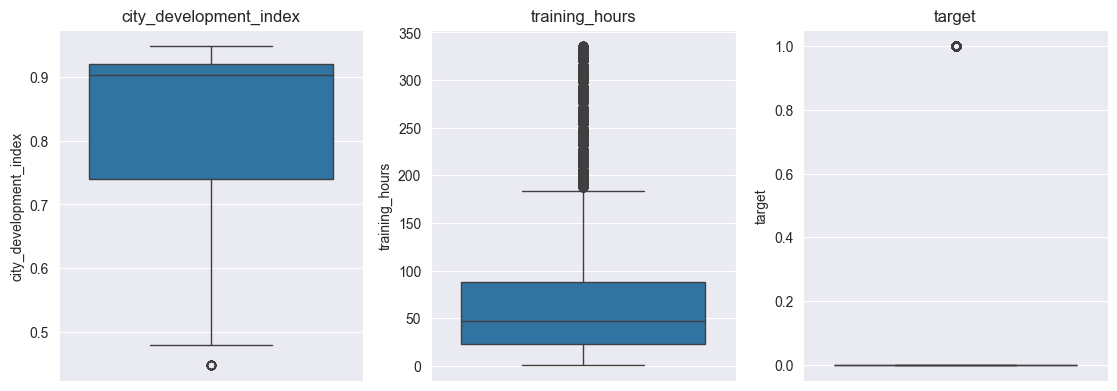

In [9]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])
# only analyse the continuous features
p = 1
fig = plt.figure(figsize=(15, 15))
for i in numeric_df:
    plt.subplot(4, 4, p)
    sns.boxplot(numeric_df[i])
    plt.title(i)
    p = p + 1
plt.tight_layout()
plt.show()

Seems like training_hours have the outliers, let's check the detail

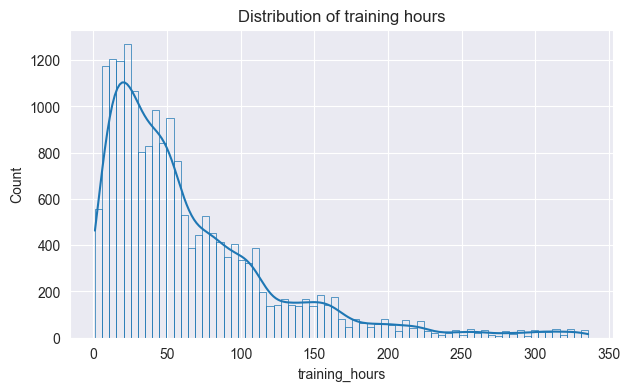

In [10]:
plt.figure(figsize=(7, 4))
sns.histplot(df.training_hours, kde=True, fill=False)
plt.title("Distribution of training hours")
plt.show()

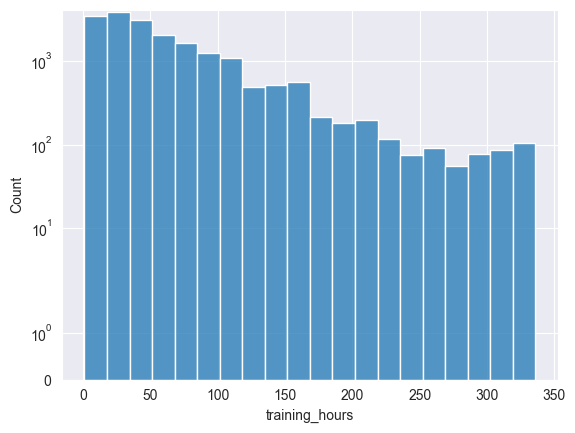

In [11]:
sns.histplot(x='training_hours', data=df, bins=20, stat='count')
plt.yscale('symlog', base=10)
plt.show()

#### The training_hour is visualizing a logarithmic distribution, so we do not deal with it as an outlier.

Next, we will look at the city_development_index, calculate the skewness and Q3, as the city_development_index, it shows nothing about the outliers, because the index can be any number between 0 and 1, any distribution is acceptable.

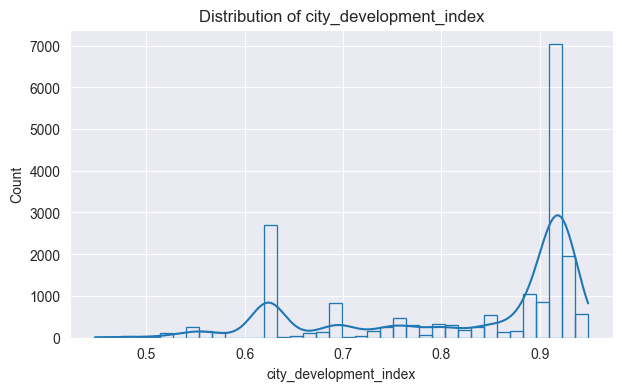

In [12]:
plt.figure(figsize=(7, 4))
sns.histplot(df.city_development_index, kde=True, fill=False)
plt.title("Distribution of city_development_index")
plt.show()

In [13]:
print("Skewness: ", df.city_development_index.skew())
print("Median: ", df.city_development_index.quantile(0.50))
Q3 = df.city_development_index.quantile(0.95)
print("Q3: ", Q3)

Skewness:  -0.9954275351977435
Median:  0.903
Q3:  0.926


##  d. Replacing parts of the dataset that are NaN with content
Now we need to have a statistic analysis to the empty value for each label, find the count, distribution and percentage to decide the solution to deal with the empty value problem.

In [14]:
# analysis of the continuous features
df.describe()

city_development_index  training_hours        target
count            19158.000000    19158.000000  19158.000000
mean                 0.828848       65.366896      0.249348
std                  0.123362       60.058462      0.432647
min                  0.448000        1.000000      0.000000
25%                  0.740000       23.000000      0.000000
50%                  0.903000       47.000000      0.000000
75%                  0.920000       88.000000      0.000000
max                  0.949000      336.000000      1.000000

In [15]:
# analysis of the categorical features
df.describe(include=['O'])

city gender      relevent_experience enrolled_university  \
count         19158  14650                    19158               18772   
unique            6      3                        2                   3   
top     city_others   Male  Has relevent experience       no_enrollment   
freq           8387  13221                    13792               13817   

       education_level major_discipline experience company_size company_type  \
count            18698            16345      19093        13220        13018   
unique               5                6         22            8            6   
top           Graduate             STEM        >20        50-99      Pvt Ltd   
freq             11598            14492       3286         3083         9817   

       last_new_job  
count         18735  
unique            6  
top               1  
freq           8040

In [16]:
print(df.isnull().values.sum())
df.isnull().sum() / len(df) * 100

20733


city                       0.000000
city_development_index     0.000000
gender                    23.530640
relevent_experience        0.000000
enrolled_university        2.014824
education_level            2.401086
major_discipline          14.683161
experience                 0.339284
company_size              30.994885
company_type              32.049274
last_new_job               2.207955
training_hours             0.000000
target                     0.000000
dtype: float64

Because the amount of missing value of label like company_size and company_value are large, we can not just replace the NaN by the value that appears the most. The company_size and company_type is slightly larger than 30%, but not achieve the higher threshold 50%, hence we will keep it and filled the NaN value. Hence, we need to check the detail statistic value first. But for other attribute, we can use the mode value to replace the NaN values.

#### Replace empty value with mean of the label
It is clear that the continuous features don't need to change the value because there is no empty value. However, for the categorical features, we still need to figure out the relation between the label and other label.
For descriptive feature gender, relevant_experience, enrolled_university, education_level, major_discipline, experience, and last_new_job, the difference of the non-null value and the total amount of data set is small. Hence, we can use the mean to replace it.
#### For company_type, although the difference of the non-null value and the total amount of data set is huge, the value which appears the most is high, we can also use the mean to replace it.

In [17]:
df['company_type'].value_counts()

company_type
Pvt Ltd                9817
Funded Startup         1001
Public Sector           955
Early Stage Startup     603
NGO                     521
Other                   121
Name: count, dtype: int64

In [18]:
df.head(5)

city  city_development_index gender      relevent_experience  \
0     city_103                   0.920   Male  Has relevent experience   
1  city_others                   0.776   Male   No relevent experience   
2      city_21                   0.624    NaN   No relevent experience   
3  city_others                   0.789    NaN   No relevent experience   
4  city_others                   0.767   Male  Has relevent experience   

  enrolled_university education_level major_discipline experience  \
0       no_enrollment        Graduate             STEM        >20   
1       no_enrollment        Graduate             STEM         15   
2    Full time course        Graduate             STEM          5   
3                 NaN        Graduate  Business Degree         <1   
4       no_enrollment         Masters             STEM        >20   

  company_size    company_type last_new_job  training_hours  target  
0          NaN             NaN            1              36       1  
1        50-99         Pvt Ltd           >4              47       0  
2          NaN             NaN        never              83       0  
3          NaN         Pvt Ltd        never              52       1  
4        50-99  Funded Startup            4               8       0

In [19]:
df["gender"].fillna(str(df["gender"].mode().values[0]), inplace=True)
df["relevent_experience"].fillna(str(df["relevent_experience"].mode().values[0]), inplace=True)
df["enrolled_university"].fillna(str(df["enrolled_university"].mode().values[0]), inplace=True)
df["education_level"].fillna(str(df["education_level"].mode().values[0]), inplace=True)
df["major_discipline"].fillna(str(df["major_discipline"].mode().values[0]), inplace=True)
df["experience"].fillna(str(df["experience"].mode().values[0]), inplace=True)
df["last_new_job"].fillna(str(df["last_new_job"].mode().values[0]), inplace=True)
df["company_type"].fillna(str(df["company_type"].mode().values[0]), inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    19158 non-null  object 
 1   city_development_index  19158 non-null  float64
 2   gender                  19158 non-null  object 
 3   relevent_experience     19158 non-null  object 
 4   enrolled_university     19158 non-null  object 
 5   education_level         19158 non-null  object 
 6   major_discipline        19158 non-null  object 
 7   experience              19158 non-null  object 
 8   company_size            13220 non-null  object 
 9   company_type            19158 non-null  object 
 10  last_new_job            19158 non-null  object 
 11  training_hours          19158 non-null  int64  
 12  target                  19158 non-null  int64  
dtypes: float64(1), int64(2), object(10)
memory usage: 1.9+ MB


See the result after we replace the empty values

In [20]:
df.head(5)
df.describe(include=['O'])

city gender      relevent_experience enrolled_university  \
count         19158  19158                    19158               19158   
unique            6      3                        2                   3   
top     city_others   Male  Has relevent experience       no_enrollment   
freq           8387  17729                    13792               14203   

       education_level major_discipline experience company_size company_type  \
count            19158            19158      19158        13220        19158   
unique               5                6         22            8            6   
top           Graduate             STEM        >20        50-99      Pvt Ltd   
freq             12058            17305       3351         3083        15957   

       last_new_job  
count         19158  
unique            6  
top               1  
freq           8463

Now it is easy to see that we replace the NaN value.
For the company_size, we can see as the following output, the distribution does not have significant difference between the two neighboring value. It is clear when it is compared to the company_type.
#### Hence, we can use company_size as the target feature, and other descriptive feature are used as the descriptive feature to train it.

### Transform the categorical feature to the countable value
For the value of company_size, experience and last_new_job, we can convert it to number, because although it is categorical, the value of it is a description of number, let's start with experience.

In [21]:
df['experience'].value_counts()

experience
>20    3351
5      1430
4      1403
3      1354
6      1216
2      1127
7      1028
10      985
9       980
8       802
15      686
11      664
14      586
1       549
<1      522
16      508
12      494
13      399
17      342
19      304
18      280
20      148
Name: count, dtype: int64

There are 22 category and for >20 category, we change it to 21, for <1 category, we change it to 0

In [22]:
df['experience'] = df['experience'].apply(lambda x: 21 if x == '>20' else (0 if x == '<1' else int(x)))
df['experience'].value_counts()

experience
21    3351
5     1430
4     1403
3     1354
6     1216
2     1127
7     1028
10     985
9      980
8      802
15     686
11     664
14     586
1      549
0      522
16     508
12     494
13     399
17     342
19     304
18     280
20     148
Name: count, dtype: int64

Then we can look at company_size, for the value like 100-500, we can use the mean of this range which is 300.

In [23]:
df['company_size'].value_counts()

company_size
50-99        3083
100-500      2571
10000+       2019
10/49        1471
1000-4999    1328
<10          1308
500-999       877
5000-9999     563
Name: count, dtype: int64

In [24]:
df['company_size'].replace('50-99', 75, inplace=True)
df['company_size'].replace('100-500', 300, inplace=True)
df['company_size'].replace('10000+', 10001, inplace=True)
df['company_size'].replace('10/49', 30, inplace=True)
df['company_size'].replace('1000-4999', 3000, inplace=True)
df['company_size'].replace('<10', 9, inplace=True)
df['company_size'].replace('500-999', 750, inplace=True)
df['company_size'].replace('5000-9999', 7500, inplace=True)
df['company_size'].value_counts()

company_size
75.0       3083
300.0      2571
10001.0    2019
30.0       1471
3000.0     1328
9.0        1308
750.0       877
7500.0      563
Name: count, dtype: int64

Now let's deal with the last_new_job. Change >4 to 5, never to 0

In [25]:
df['last_new_job'].value_counts()

last_new_job
1        8463
>4       3290
2        2900
never    2452
4        1029
3        1024
Name: count, dtype: int64

In [26]:
df['last_new_job'] = df['last_new_job'].apply(lambda x: 5 if x == '>4' else (0 if x == 'never' else int(x)))
df['last_new_job'].value_counts()

last_new_job
1    8463
5    3290
2    2900
0    2452
4    1029
3    1024
Name: count, dtype: int64

In [27]:
df.head()

city  city_development_index gender      relevent_experience  \
0     city_103                   0.920   Male  Has relevent experience   
1  city_others                   0.776   Male   No relevent experience   
2      city_21                   0.624   Male   No relevent experience   
3  city_others                   0.789   Male   No relevent experience   
4  city_others                   0.767   Male  Has relevent experience   

  enrolled_university education_level major_discipline  experience  \
0       no_enrollment        Graduate             STEM          21   
1       no_enrollment        Graduate             STEM          15   
2    Full time course        Graduate             STEM           5   
3       no_enrollment        Graduate  Business Degree           0   
4       no_enrollment         Masters             STEM          21   

   company_size    company_type  last_new_job  training_hours  target  
0           NaN         Pvt Ltd             1              36       1  
1          75.0         Pvt Ltd             5              47       0  
2           NaN         Pvt Ltd             0              83       0  
3           NaN         Pvt Ltd             0              52       1  
4          75.0  Funded Startup             4               8       0

### Label encoding
We need to look at every categorical feature first. If the values are associated with degrees, then label encoding is needed.
#### Now we have city, gender, relevent_experience, enrolled_university, education_level, major_discipline.
#### Relevent_experience, education_level fit this standard

In [28]:
continuousFeatures = pd.concat([df[['city_development_index', 'relevent_experience', 'education_level', 'experience',
                                    'last_new_job', 'training_hours']]], axis=1)
# in the continuousFeatures, include the features that are continuous and are modified by label encoding
categoricalFeatures = pd.concat([df[['city', 'gender', 'enrolled_university', 'major_discipline', 'company_type']]],
                                axis=1)
# in the categoricalFeature, include the featured that will be modified by one-hot encoding
continuousFeatures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city_development_index  19158 non-null  float64
 1   relevent_experience     19158 non-null  object 
 2   education_level         19158 non-null  object 
 3   experience              19158 non-null  int64  
 4   last_new_job            19158 non-null  int64  
 5   training_hours          19158 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 898.2+ KB


In [29]:
continuousFeatures['relevent_experience'].value_counts()

relevent_experience
Has relevent experience    13792
No relevent experience      5366
Name: count, dtype: int64

In [30]:
continuousFeatures['relevent_experience'] = continuousFeatures['relevent_experience'].apply(
    lambda x: 1 if x == 'Has relevent experience' else 0)
continuousFeatures['relevent_experience'].value_counts()

relevent_experience
1    13792
0     5366
Name: count, dtype: int64

In [31]:
continuousFeatures['education_level'].value_counts()

education_level
Graduate          12058
Masters            4361
High School        2017
Phd                 414
Primary School      308
Name: count, dtype: int64

In [32]:
continuousFeatures['education_level'].replace('Primary School', 1, inplace=True)
continuousFeatures['education_level'].replace('High School', 2, inplace=True)
continuousFeatures['education_level'].replace('Graduate', 3, inplace=True)
continuousFeatures['education_level'].replace('Masters', 4, inplace=True)
continuousFeatures['education_level'].replace('Phd', 5, inplace=True)
continuousFeatures['education_level'].value_counts()

education_level
3    12058
4     4361
2     2017
5      414
1      308
Name: count, dtype: int64

#### Now we can see the detail after we finish the label encoding

In [33]:
categoricalFeatures.head(10)

city gender enrolled_university major_discipline    company_type
0     city_103   Male       no_enrollment             STEM         Pvt Ltd
1  city_others   Male       no_enrollment             STEM         Pvt Ltd
2      city_21   Male    Full time course             STEM         Pvt Ltd
3  city_others   Male       no_enrollment  Business Degree         Pvt Ltd
4  city_others   Male       no_enrollment             STEM  Funded Startup
5  city_others   Male    Part time course             STEM         Pvt Ltd
6     city_160   Male       no_enrollment             STEM  Funded Startup
7  city_others   Male       no_enrollment             STEM         Pvt Ltd
8     city_103   Male       no_enrollment             STEM         Pvt Ltd
9     city_103   Male       no_enrollment             STEM         Pvt Ltd

### One-hot encoding
One-hot encoding simplifies categorical data for machine learning by converting categories into binary format. It ensures compatibility with algorithms, prevents bias, and maintains distinct representation for each category. This method is non-ordinal, allowing clear interpretation and easier analysis due to the distinct binary values representing each category.

In [34]:
categoricalFeatures.head()

city gender enrolled_university major_discipline    company_type
0     city_103   Male       no_enrollment             STEM         Pvt Ltd
1  city_others   Male       no_enrollment             STEM         Pvt Ltd
2      city_21   Male    Full time course             STEM         Pvt Ltd
3  city_others   Male       no_enrollment  Business Degree         Pvt Ltd
4  city_others   Male       no_enrollment             STEM  Funded Startup

In [35]:
targetFeature = df['target']
onehot_cate = pd.get_dummies(categoricalFeatures, prefix=categoricalFeatures.columns,
                             columns=categoricalFeatures.columns, drop_first=False)
onehot_cate.head()

city_city_103  city_city_114  city_city_16  city_city_160  city_city_21  \
0           True          False         False          False         False   
1          False          False         False          False         False   
2          False          False         False          False          True   
3          False          False         False          False         False   
4          False          False         False          False         False   

   city_city_others  gender_Female  gender_Male  gender_Other  \
0             False          False         True         False   
1              True          False         True         False   
2             False          False         True         False   
3              True          False         True         False   
4              True          False         True         False   

   enrolled_university_Full time course  ...  major_discipline_Humanities  \
0                                 False  ...                        False   
1                                 False  ...                        False   
2                                  True  ...                        False   
3                                 False  ...                        False   
4                                 False  ...                        False   

   major_discipline_No Major  major_discipline_Other  major_discipline_STEM  \
0                      False                   False                   True   
1                      False                   False                   True   
2                      False                   False                   True   
3                      False                   False                  False   
4                      False                   False                   True   

   company_type_Early Stage Startup  company_type_Funded Startup  \
0                             False                        False   
1                             False                        False   
2                             False                        False   
3                             False                        False   
4                             False                         True   

   company_type_NGO  company_type_Other  company_type_Public Sector  \
0             False               False                       False   
1             False               False                       False   
2             False               False                       False   
3             False               False                       False   
4             False               False                       False   

   company_type_Pvt Ltd  
0                  True  
1                  True  
2                  True  
3                  True  
4                 False  

[5 rows x 24 columns]

I do not change the value in df for the future visualization, but the categoricalFeatures' values are changed.

In [36]:
df.head()

city  city_development_index gender      relevent_experience  \
0     city_103                   0.920   Male  Has relevent experience   
1  city_others                   0.776   Male   No relevent experience   
2      city_21                   0.624   Male   No relevent experience   
3  city_others                   0.789   Male   No relevent experience   
4  city_others                   0.767   Male  Has relevent experience   

  enrolled_university education_level major_discipline  experience  \
0       no_enrollment        Graduate             STEM          21   
1       no_enrollment        Graduate             STEM          15   
2    Full time course        Graduate             STEM           5   
3       no_enrollment        Graduate  Business Degree           0   
4       no_enrollment         Masters             STEM          21   

   company_size    company_type  last_new_job  training_hours  target  
0           NaN         Pvt Ltd             1              36       1  
1          75.0         Pvt Ltd             5              47       0  
2           NaN         Pvt Ltd             0              83       0  
3           NaN         Pvt Ltd             0              52       1  
4          75.0  Funded Startup             4               8       0

### Normalize the data
The reason why we need to normalize is that we need to use the KNN model. KNN relies on distance metrics to determine nearest neighbors. Normalizing the data is essential for KNN because it ensures that all features contribute equally to the distance calculations. When features are on different scales, those with larger scales can disproportionately influence the distance metrics. Normalization standardizes the features, ensuring fair and accurate distance measurements, resulting in a more reliable KNN model.

Given the wide distribution of values in my dataset, employing RobustScaler is prudent. RobustScaler is ideal due to its resilience against outliers and its ability to handle data with a wider spread. This method utilizes the median and interquartile range (IQR) for scaling, making it suitable for datasets with large variances and the presence of outliers. When using K-Nearest Neighbors (KNN), RobustScaler is preferable due to its ability to mitigate the impact of outliers, enhancing the robustness of distance-based calculations, thereby improving KNN's performance.

In [37]:
scaler = RobustScaler()
continuousFeatures = pd.DataFrame(scaler.fit_transform(continuousFeatures), columns=continuousFeatures.columns,
                                  index=continuousFeatures.index)
continuousFeatures.head()

city_development_index  relevent_experience  education_level  experience  \
0                0.094444                  0.0              0.0    1.000000   
1               -0.705556                 -1.0              0.0    0.500000   
2               -1.550000                 -1.0              0.0   -0.333333   
3               -0.633333                 -1.0              0.0   -0.750000   
4               -0.755556                  0.0              1.0    1.000000   

   last_new_job  training_hours  
0           0.0       -0.169231  
1           2.0        0.000000  
2          -0.5        0.553846  
3          -0.5        0.076923  
4           1.5       -0.600000

In [38]:
continuousFeatures.describe()

city_development_index  relevent_experience  education_level  \
count            19158.000000         19158.000000     19158.000000   
mean                -0.411956            -0.280092         0.133417   
std                  0.685343             0.449056         0.682559   
min                 -2.527778            -1.000000        -2.000000   
25%                 -0.905556            -1.000000         0.000000   
50%                  0.000000             0.000000         0.000000   
75%                  0.094444             0.000000         0.000000   
max                  0.255556             0.000000         2.000000   

         experience  last_new_job  training_hours  
count  19158.000000  19158.000000    19158.000000  
mean       0.094760      0.489169        0.282568  
std        0.566262      0.831751        0.923976  
min       -0.750000     -0.500000       -0.707692  
25%       -0.416667      0.000000       -0.369231  
50%        0.000000      0.000000        0.000000  
75%        0.583333      1.000000        0.630769  
max        1.000000      2.000000        4.446154

### We have onehot_cate and continuousFeature which are all preprocessed.

In [39]:
onehot_cate.describe()

city_city_103 city_city_114 city_city_16 city_city_160 city_city_21  \
count          19158         19158        19158         19158        19158   
unique             2             2            2             2            2   
top            False         False        False         False        False   
freq           14803         17822        17625         18313        16456   

       city_city_others gender_Female gender_Male gender_Other  \
count             19158         19158       19158        19158   
unique                2             2           2            2   
top               False         False        True        False   
freq              10771         17920       17729        18967   

       enrolled_university_Full time course  ... major_discipline_Humanities  \
count                                 19158  ...                       19158   
unique                                    2  ...                           2   
top                                   False  ...                       False   
freq                                  15401  ...                       18489   

       major_discipline_No Major major_discipline_Other major_discipline_STEM  \
count                      19158                  19158                 19158   
unique                         2                      2                     2   
top                        False                  False                  True   
freq                       18935                  18777                 17305   

       company_type_Early Stage Startup company_type_Funded Startup  \
count                             19158                       19158   
unique                                2                           2   
top                               False                       False   
freq                              18555                       18157   

       company_type_NGO company_type_Other company_type_Public Sector  \
count             19158              19158                      19158   
unique                2                  2                          2   
top               False              False                      False   
freq              18637              19037                      18203   

       company_type_Pvt Ltd  
count                 19158  
unique                    2  
top                    True  
freq                  15957  

[4 rows x 24 columns]

In [40]:
continuousFeatures.describe()

city_development_index  relevent_experience  education_level  \
count            19158.000000         19158.000000     19158.000000   
mean                -0.411956            -0.280092         0.133417   
std                  0.685343             0.449056         0.682559   
min                 -2.527778            -1.000000        -2.000000   
25%                 -0.905556            -1.000000         0.000000   
50%                  0.000000             0.000000         0.000000   
75%                  0.094444             0.000000         0.000000   
max                  0.255556             0.000000         2.000000   

         experience  last_new_job  training_hours  
count  19158.000000  19158.000000    19158.000000  
mean       0.094760      0.489169        0.282568  
std        0.566262      0.831751        0.923976  
min       -0.750000     -0.500000       -0.707692  
25%       -0.416667      0.000000       -0.369231  
50%        0.000000      0.000000        0.000000  
75%        0.583333      1.000000        0.630769  
max        1.000000      2.000000        4.446154

### we can start with analyzing the relationship between the company_size and other descriptive features.

In [41]:
df["company_size"].value_counts()

company_size
75.0       3083
300.0      2571
10001.0    2019
30.0       1471
3000.0     1328
9.0        1308
750.0       877
7500.0      563
Name: count, dtype: int64

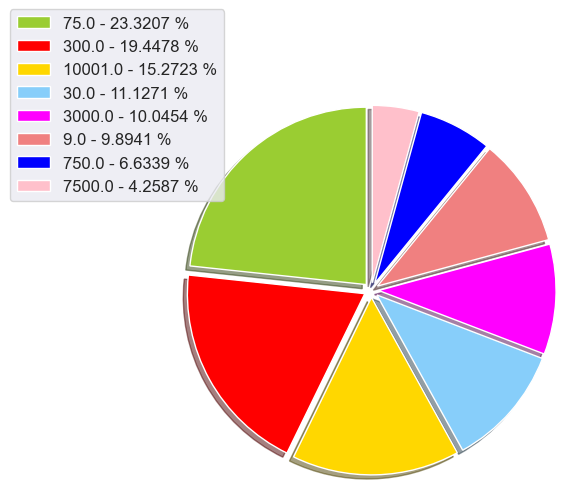

In [42]:
size_value_counts = df['company_size'].value_counts()
x = np.char.array([str(i) for i in size_value_counts.index])
y = np.array(size_value_counts.values)
colors = ['yellowgreen', 'red', 'gold', 'lightskyblue', 'magenta', 'lightcoral', 'blue', 'pink', 'darkgreen', 'yellow',
          'grey', 'violet', 'white', 'cyan'][:len(size_value_counts.index)]
explode = [0.05] * len(size_value_counts.index)
porcent = 100. * y / y.sum()

patches, texts = plt.pie(y, colors=colors, startangle=90, radius=1.2, shadow=True,
                         wedgeprops={'linewidth': 1, 'linestyle': 'solid', 'antialiased': True}, explode=explode)
labels = ['{0} - {1:1.4f} %'.format(i, j) for i, j in zip(x, porcent)]

sort_legend = True
if sort_legend:
    patches, labels, dummy = zip(*sorted(zip(patches, labels, y),
                                         key=lambda x: x[2],
                                         reverse=True))

plt.legend(patches, labels, loc='center left', bbox_to_anchor=(-0.5, 1.),
           fontsize=12)

plt.show()

Now it is clear to see the composition of the company-size, there is no category with significant small amount, hence, these are no category should be deleted.

### Use the Decision Tree to predict company_size
First we analyze the correlation between other label and company_size, second we get the train set and target set. In this step, we create train_size dataframe to train the model.

In [43]:
concatenated_df = pd.concat([onehot_cate, continuousFeatures, df['company_size']], axis=1)
train_size = concatenated_df.dropna(subset=['company_size'])  # we use this set to train the model
train_size_target = train_size['company_size']
del train_size['company_size']
pred_size = concatenated_df[concatenated_df['company_size'].isnull()]  # we need to predict this set
pred_size_target = pd.DataFrame(pred_size['company_size'])
del pred_size['company_size']
train_size.info()
pd.DataFrame(train_size_target).head()
pred_size.info()
pred_size_target.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13220 entries, 1 to 19156
Data columns (total 30 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   city_city_103                         13220 non-null  bool   
 1   city_city_114                         13220 non-null  bool   
 2   city_city_16                          13220 non-null  bool   
 3   city_city_160                         13220 non-null  bool   
 4   city_city_21                          13220 non-null  bool   
 5   city_city_others                      13220 non-null  bool   
 6   gender_Female                         13220 non-null  bool   
 7   gender_Male                           13220 non-null  bool   
 8   gender_Other                          13220 non-null  bool   
 9   enrolled_university_Full time course  13220 non-null  bool   
 10  enrolled_university_Part time course  13220 non-null  bool   
 11  enrolled_university_

In [44]:
size_corr = concatenated_df.corr()
print(size_corr)

                                      city_city_103  city_city_114  \
city_city_103                              1.000000      -0.148506   
city_city_114                             -0.148506       1.000000   
city_city_16                              -0.159965      -0.080748   
city_city_160                             -0.116511      -0.058813   
city_city_21                              -0.219786      -0.110944   
city_city_others                          -0.478624      -0.241602   
gender_Female                              0.070201      -0.021950   
gender_Male                               -0.073553       0.020790   
gender_Other                               0.020787      -0.000659   
enrolled_university_Full time course      -0.106037       0.003614   
enrolled_university_Part time course      -0.045437       0.019854   
enrolled_university_no_enrollment          0.121271      -0.014255   
major_discipline_Arts                      0.083450      -0.006540   
major_discipline_Bus

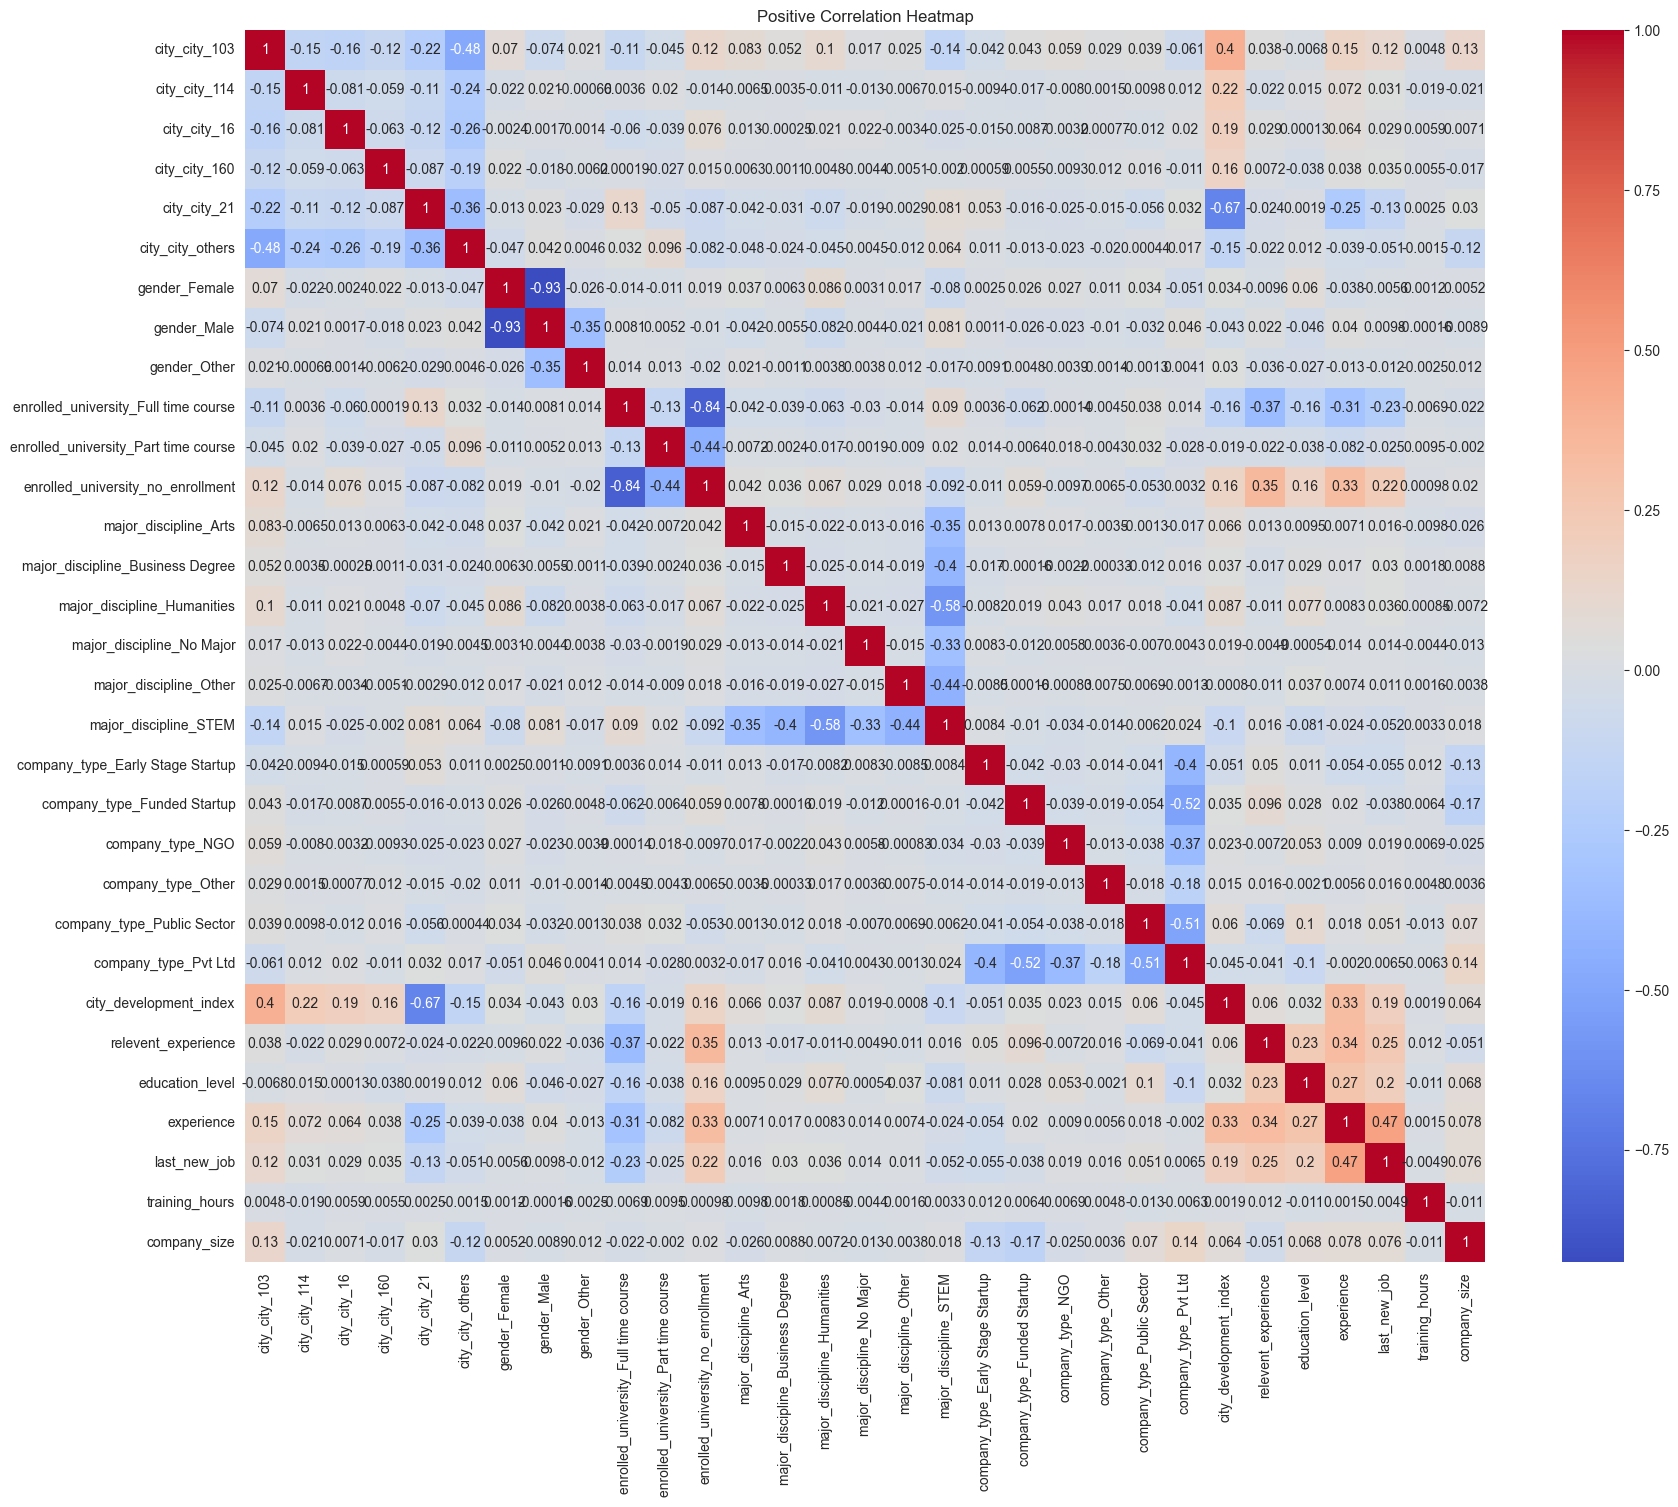

In [45]:
plt.figure(figsize=(20, 16))
sns.heatmap(size_corr, annot=True, cmap='coolwarm')
plt.title('Positive Correlation Heatmap')
plt.show()

#### From this graph, we can see that there is no strongly correlative feature, so we can use all feature to train the model.

### Now we can use the decision tree to train the dataset and find the result

We train the decision tree and fill the NaN value. Now we have the concatenated_df as the set for target training, but the company_size value should be preprocesssed later.

In [46]:
entropy_tree_size = DecisionTreeClassifier(criterion='entropy', random_state=42)
entropy_tree_size.fit(train_size, train_size_target)
pred_size_target = entropy_tree_size.predict(pred_size)

concatenated_df.loc[concatenated_df['company_size'].isnull(), 'company_size'] = pred_size_target
df.loc[df['company_size'].isnull(), 'company_size'] = pred_size_target
concatenated_df.info()
concatenated_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 31 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   city_city_103                         19158 non-null  bool   
 1   city_city_114                         19158 non-null  bool   
 2   city_city_16                          19158 non-null  bool   
 3   city_city_160                         19158 non-null  bool   
 4   city_city_21                          19158 non-null  bool   
 5   city_city_others                      19158 non-null  bool   
 6   gender_Female                         19158 non-null  bool   
 7   gender_Male                           19158 non-null  bool   
 8   gender_Other                          19158 non-null  bool   
 9   enrolled_university_Full time course  19158 non-null  bool   
 10  enrolled_university_Part time course  19158 non-null  bool   
 11  enrolled_univer

city_city_103  city_city_114  city_city_16  city_city_160  city_city_21  \
0           True          False         False          False         False   
1          False          False         False          False         False   
2          False          False         False          False          True   
3          False          False         False          False         False   
4          False          False         False          False         False   

   city_city_others  gender_Female  gender_Male  gender_Other  \
0             False          False         True         False   
1              True          False         True         False   
2             False          False         True         False   
3              True          False         True         False   
4              True          False         True         False   

   enrolled_university_Full time course  ...  company_type_Other  \
0                                 False  ...               False   
1                                 False  ...               False   
2                                  True  ...               False   
3                                 False  ...               False   
4                                 False  ...               False   

   company_type_Public Sector  company_type_Pvt Ltd  city_development_index  \
0                       False                  True                0.094444   
1                       False                  True               -0.705556   
2                       False                  True               -1.550000   
3                       False                  True               -0.633333   
4                       False                 False               -0.755556   

   relevent_experience  education_level  experience  last_new_job  \
0                  0.0              0.0    1.000000           0.0   
1                 -1.0              0.0    0.500000           2.0   
2                 -1.0              0.0   -0.333333          -0.5   
3                 -1.0              0.0   -0.750000          -0.5   
4                  0.0              1.0    1.000000           1.5   

   training_hours  company_size  
0       -0.169231         300.0  
1        0.000000          75.0  
2        0.553846        7500.0  
3        0.076923          30.0  
4       -0.600000          75.0  

[5 rows x 31 columns]

In [47]:
concatenated_df['company_size'].value_counts()

company_size
75.0       4377
300.0      3727
10001.0    3062
30.0       2132
3000.0     1966
9.0        1774
750.0      1248
7500.0      872
Name: count, dtype: int64

The company_size was already done the removing NaN value process.

### Normalize the company_size values

In [48]:
column_data = concatenated_df['company_size'].values.reshape(-1, 1)
scaled_data = scaler.fit_transform(column_data)
concatenated_df['company_size'] = scaled_data
concatenated_df.head(10)

city_city_103  city_city_114  city_city_16  city_city_160  city_city_21  \
0           True          False         False          False         False   
1          False          False         False          False         False   
2          False          False         False          False          True   
3          False          False         False          False         False   
4          False          False         False          False         False   
5          False          False         False          False         False   
6          False          False         False           True         False   
7          False          False         False          False         False   
8           True          False         False          False         False   
9           True          False         False          False         False   

   city_city_others  gender_Female  gender_Male  gender_Other  \
0             False          False         True         False   
1              True          False         True         False   
2             False          False         True         False   
3              True          False         True         False   
4              True          False         True         False   
5              True          False         True         False   
6             False          False         True         False   
7              True          False         True         False   
8             False          False         True         False   
9             False          False         True         False   

   enrolled_university_Full time course  ...  company_type_Other  \
0                                 False  ...               False   
1                                 False  ...               False   
2                                  True  ...               False   
3                                 False  ...               False   
4                                 False  ...               False   
5                                 False  ...               False   
6                                 False  ...               False   
7                                 False  ...               False   
8                                 False  ...               False   
9                                 False  ...               False   

   company_type_Public Sector  company_type_Pvt Ltd  city_development_index  \
0                       False                  True                0.094444   
1                       False                  True               -0.705556   
2                       False                  True               -1.550000   
3                       False                  True               -0.633333   
4                       False                 False               -0.755556   
5                       False                  True               -0.772222   
6                       False                 False                0.094444   
7                       False                  True               -0.783333   
8                       False                  True                0.094444   
9                       False                  True                0.094444   

   relevent_experience  education_level  experience  last_new_job  \
0                  0.0              0.0    1.000000           0.0   
1                 -1.0              0.0    0.500000           2.0   
2                 -1.0              0.0   -0.333333          -0.5   
3                 -1.0              0.0   -0.750000          -0.5   
4                  0.0              1.0    1.000000           1.5   
5                  0.0              0.0    0.166667           0.0   
6                  0.0             -1.0   -0.333333           0.0   
7                  0.0              0.0    0.333333           2.0   
8                  0.0              0.0   -0.166667           0.0   
9                  0.0              0.0    0.666667           2.0   

   training_hours  company_size  
0       -0.1692

In [49]:
concatenated_df.replace(True, 1, inplace=True)
concatenated_df.replace(False, 0, inplace=True)
concatenated_df.head()

city_city_103  city_city_114  city_city_16  city_city_160  city_city_21  \
0              1              0             0              0             0   
1              0              0             0              0             0   
2              0              0             0              0             1   
3              0              0             0              0             0   
4              0              0             0              0             0   

   city_city_others  gender_Female  gender_Male  gender_Other  \
0                 0              0            1             0   
1                 1              0            1             0   
2                 0              0            1             0   
3                 1              0            1             0   
4                 1              0            1             0   

   enrolled_university_Full time course  ...  company_type_Other  \
0                                     0  ...                   0   
1                                     0  ...                   0   
2                                     1  ...                   0   
3                                     0  ...                   0   
4                                     0  ...                   0   

   company_type_Public Sector  company_type_Pvt Ltd  city_development_index  \
0                           0                     1                0.094444   
1                           0                     1               -0.705556   
2                           0                     1               -1.550000   
3                           0                     1               -0.633333   
4                           0                     0               -0.755556   

   relevent_experience  education_level  experience  last_new_job  \
0                  0.0              0.0    1.000000           0.0   
1                 -1.0              0.0    0.500000           2.0   
2                 -1.0              0.0   -0.333333          -0.5   
3                 -1.0              0.0   -0.750000          -0.5   
4                  0.0              1.0    1.000000           1.5   

   training_hours  company_size  
0       -0.169231      0.000000  
1        0.000000     -0.076923  
2        0.553846      2.461538  
3        0.076923     -0.092308  
4       -0.600000     -0.076923  

[5 rows x 31 columns]

In [50]:
df.count()

city                      19158
city_development_index    19158
gender                    19158
relevent_experience       19158
enrolled_university       19158
education_level           19158
major_discipline          19158
experience                19158
company_size              19158
company_type              19158
last_new_job              19158
training_hours            19158
target                    19158
dtype: int64

## Now we get our final set! We can start the next step!

# Step3: Visualizing Data
## Target feature

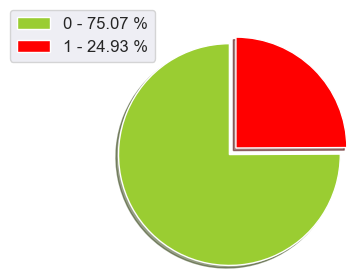

In [51]:
fig = plt.figure(figsize=(9, 3))
size_value_counts = df['target'].value_counts()
x = np.char.array([str(i) for i in size_value_counts.index])
y = np.array(size_value_counts.values)
colors = ['yellowgreen', 'red', 'gold', 'lightskyblue', 'magenta', 'lightcoral', 'blue', 'pink', 'darkgreen', 'yellow',
          'grey', 'violet', 'white', 'cyan'][:len(size_value_counts.index)]
explode = [0.05] * len(size_value_counts.index)
porcent = 100. * y / y.sum()

patches, texts = plt.pie(y, colors=colors, startangle=90, radius=1.2, shadow=True,
                         wedgeprops={'linewidth': 1, 'linestyle': 'solid', 'antialiased': True}, explode=explode)
labels = ['{0} - {1:1.2f} %'.format(i, j) for i, j in zip(x, porcent)]

sort_legend = True
if sort_legend:
    patches, labels, dummy = zip(*sorted(zip(patches, labels, y),
                                         key=lambda x: x[2],
                                         reverse=True))

plt.legend(patches, labels, loc='center left', bbox_to_anchor=(-0.5, 1.),
           fontsize=12)

plt.show()

### It's clear that 0 value in target it more than 1

## Descriptive feature individually

In [52]:
df.describe()

city_development_index    experience  company_size  last_new_job  \
count            19158.000000  19158.000000  19158.000000  19158.000000   
mean                 0.828848     10.137123   2376.206441      1.978338   
std                  0.123362      6.795143   3725.568201      1.663502   
min                  0.448000      0.000000      9.000000      0.000000   
25%                  0.740000      4.000000     75.000000      1.000000   
50%                  0.903000      9.000000    300.000000      1.000000   
75%                  0.920000     16.000000   3000.000000      3.000000   
max                  0.949000     21.000000  10001.000000      5.000000   

       training_hours        target  
count    19158.000000  19158.000000  
mean        65.366896      0.249348  
std         60.058462      0.432647  
min          1.000000      0.000000  
25%         23.000000      0.000000  
50%         47.000000      0.000000  
75%         88.000000      0.000000  
max        336.000000      1.000000

In [53]:
df.describe(include="O")

city gender      relevent_experience enrolled_university  \
count         19158  19158                    19158               19158   
unique            6      3                        2                   3   
top     city_others   Male  Has relevent experience       no_enrollment   
freq           8387  17729                    13792               14203   

       education_level major_discipline company_type  
count            19158            19158        19158  
unique               5                6            6  
top           Graduate             STEM      Pvt Ltd  
freq             12058            17305        15957

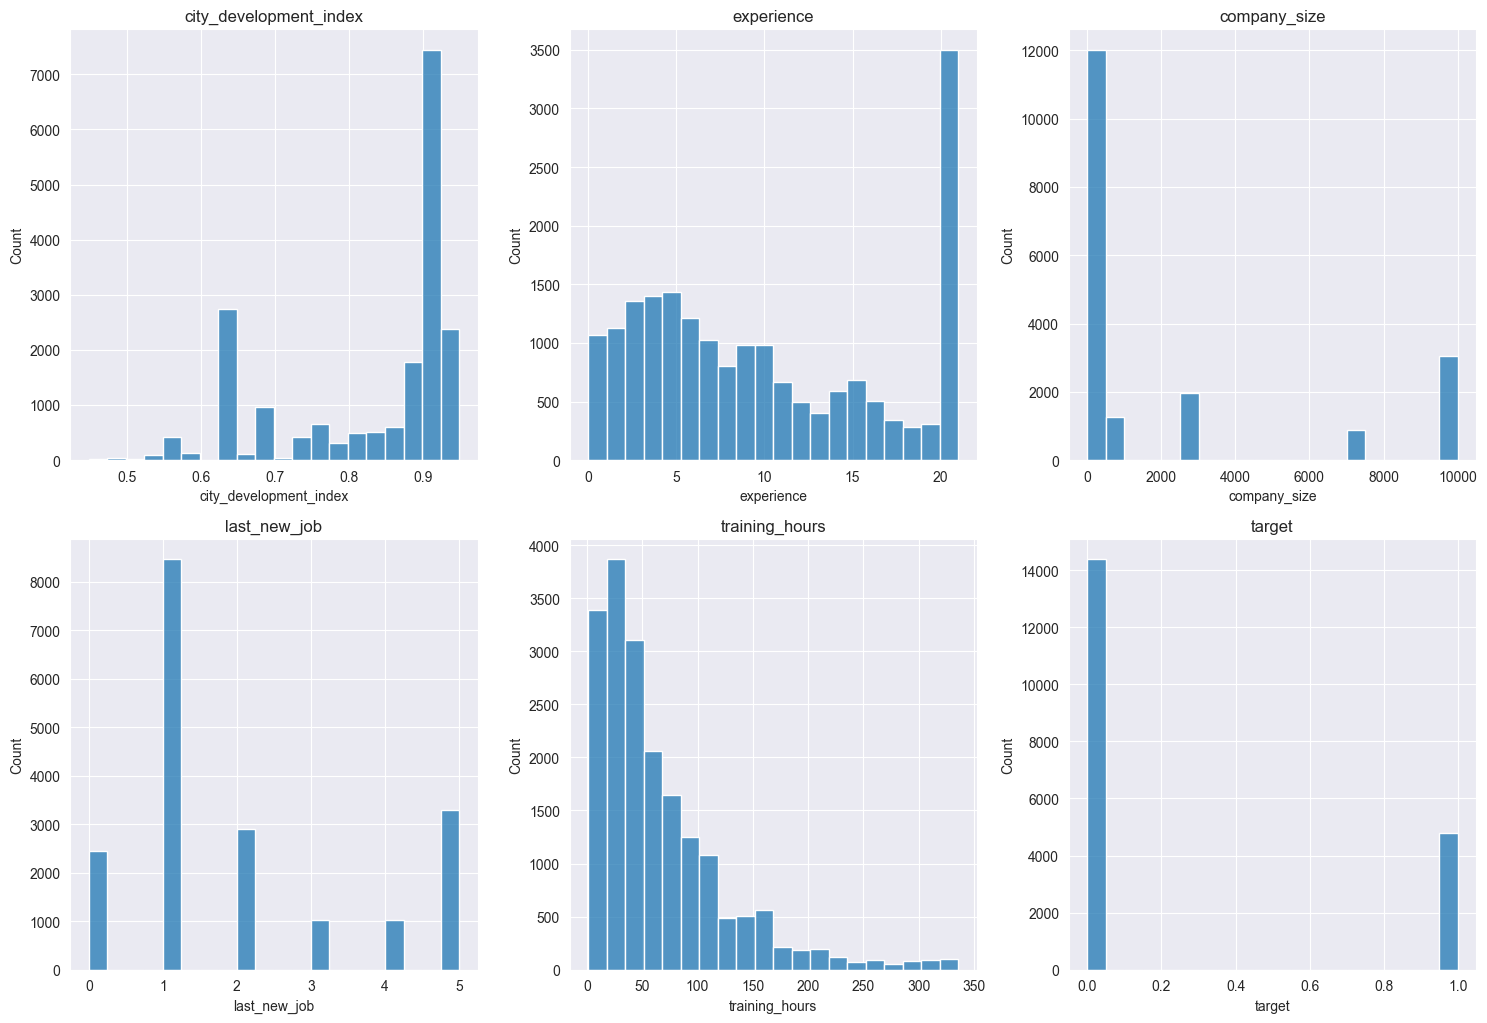

In [54]:
cat_df = df.select_dtypes(exclude="O")
# only analyse the continuous features
p = 1
fig = plt.figure(figsize=(15, 15))
for i in cat_df:
    plt.subplot(3, 3, p)
    sns.histplot(x=cat_df[i], data=df, bins=20, stat='count')
    plt.title(i)
    p = p + 1
plt.tight_layout()
plt.show()

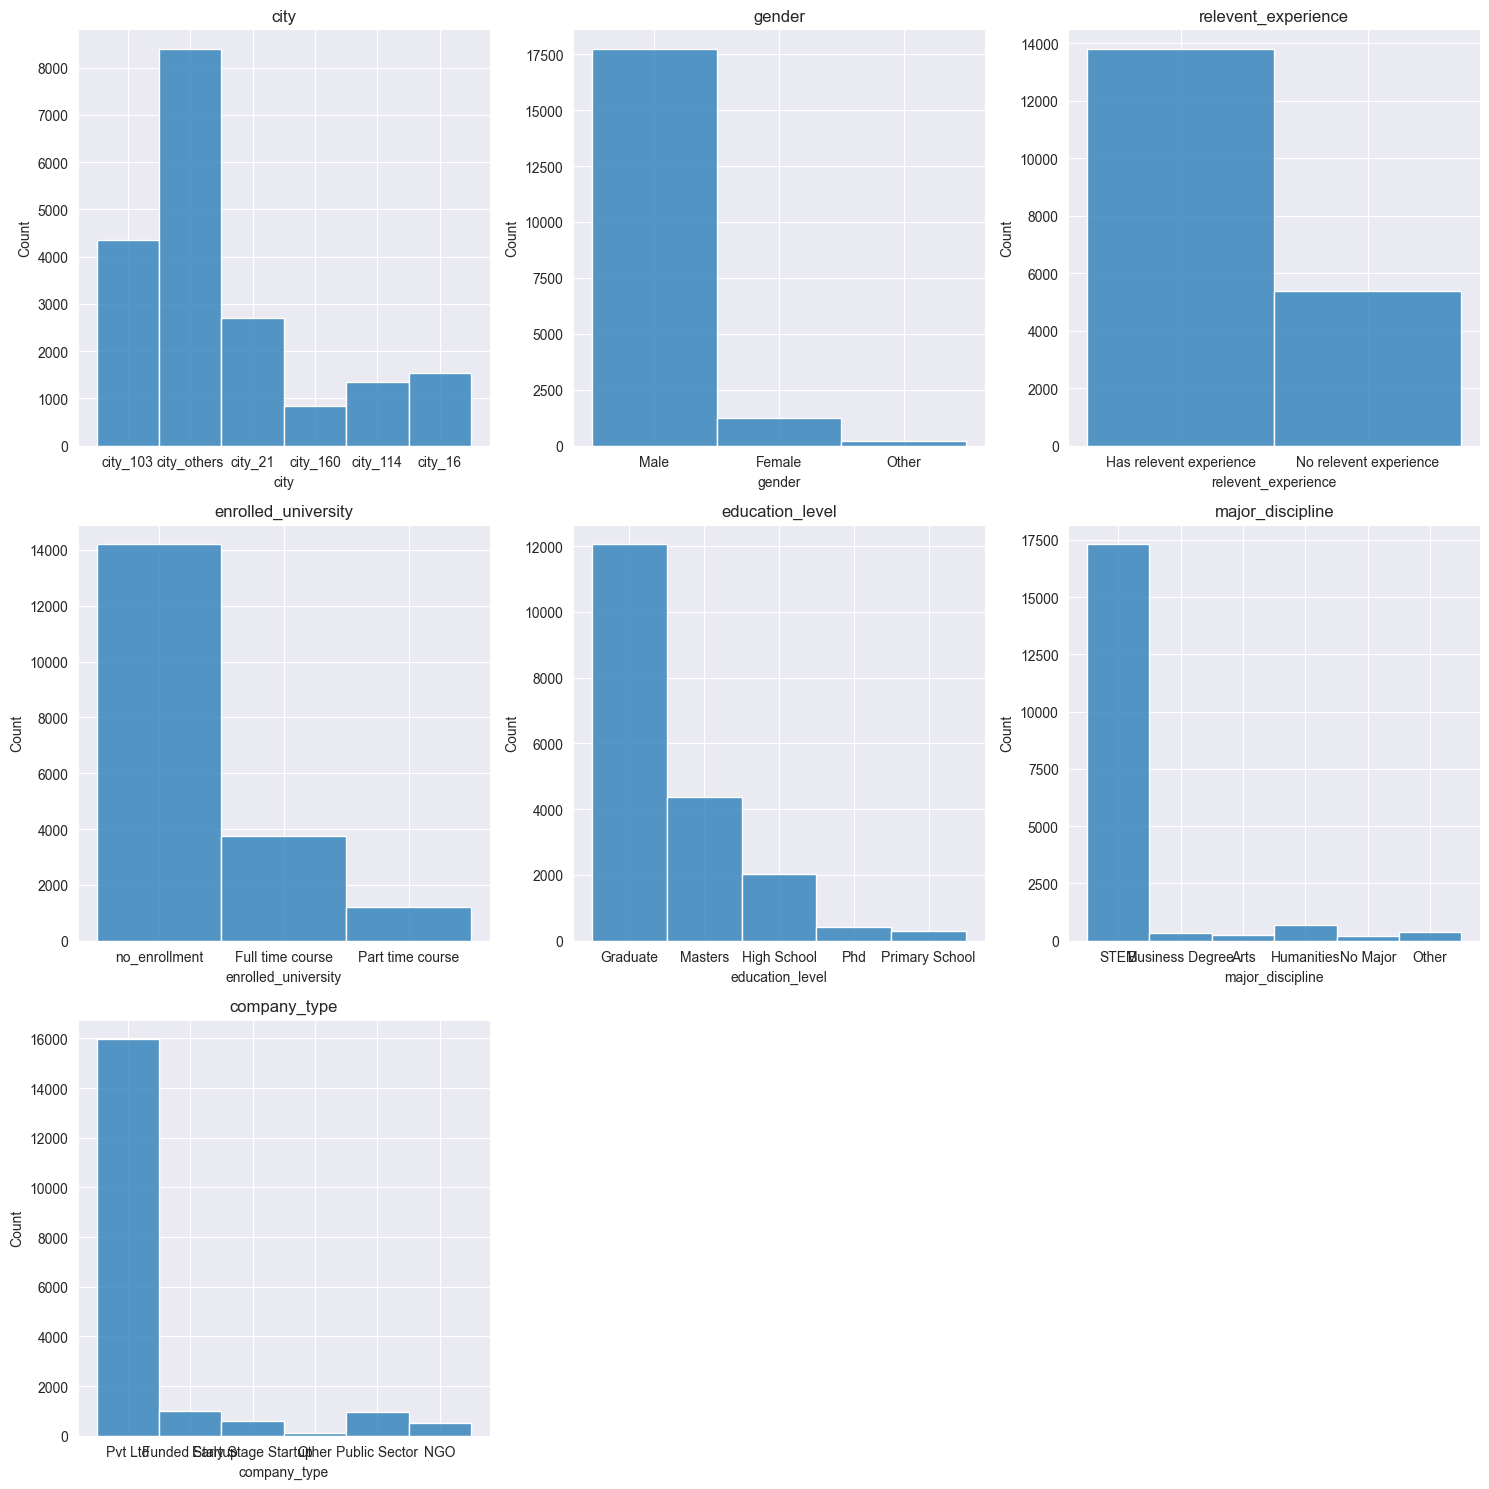

In [55]:
cat_df = df.select_dtypes(include="O")
# only analyse the continuous features
p = 1
fig = plt.figure(figsize=(15, 15))
for i in cat_df:
    plt.subplot(3, 3, p)
    sns.histplot(x=cat_df[i], data=df, bins=20, stat='count')
    plt.title(i)
    p = p + 1
plt.tight_layout()
plt.show()

From these diagrams, we can see the distribution of the attributes. As anticipated, the majority of job seekers in the IT sector have educational backgrounds related to STEM (Science, Technology, Engineering, and Mathematics), and a prevalent proportion of companies are categorized as Pvt. Within the IT industry, the number of male professionals surpasses that of females, aligning with the gender distribution observed in our dataset.

Moreover, the dataset indicates a trend where individuals with higher education levels are less represented in the survey. Clearly, there is a higher prevalence of experienced professionals in our dataset, and individuals with shorter training durations are more numerous. These observations summarize our analysis of the dataset itself.

## Descriptive feature with Target individually
Now we can analyze the attribute with target.

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    19158 non-null  object 
 1   city_development_index  19158 non-null  float64
 2   gender                  19158 non-null  object 
 3   relevent_experience     19158 non-null  object 
 4   enrolled_university     19158 non-null  object 
 5   education_level         19158 non-null  object 
 6   major_discipline        19158 non-null  object 
 7   experience              19158 non-null  int64  
 8   company_size            19158 non-null  float64
 9   company_type            19158 non-null  object 
 10  last_new_job            19158 non-null  int64  
 11  training_hours          19158 non-null  int64  
 12  target                  19158 non-null  int64  
dtypes: float64(2), int64(4), object(7)
memory usage: 1.9+ MB


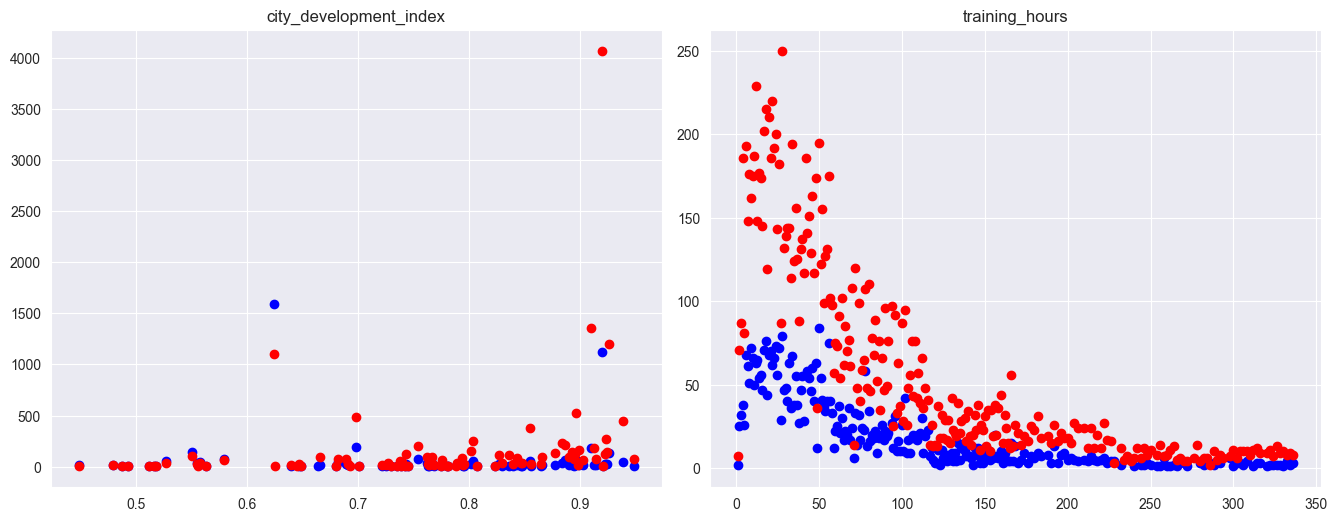

In [57]:
p = 1
fig = plt.figure(figsize=(20, 15))
lst = ['city_development_index', 'training_hours']
for i in lst:
    x_class1 = df[df['target'] == 1][i].value_counts().index
    y_class1 = df[df['target'] == 1][i].value_counts().values

    x_class2 = df[df['target'] == 0][i].value_counts().index
    y_class2 = df[df['target'] == 0][i].value_counts().values
    plt.subplot(3, 3, p)
    plt.scatter(x_class1, y_class1, label='Target 1', c='blue')
    plt.scatter(x_class2, y_class2, label='Target 0', c='red')
    plt.title(i)
    p = p + 1
plt.tight_layout()
plt.show()

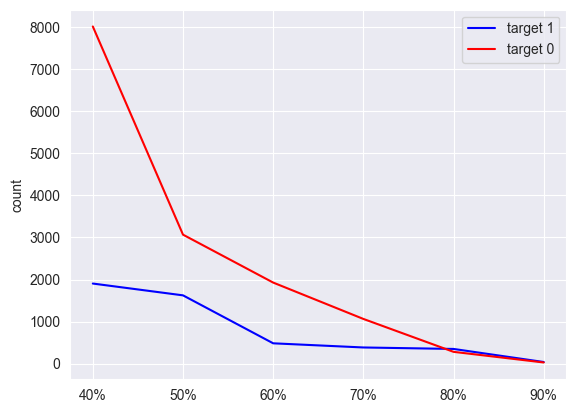

In [58]:
labels = ['40%', '50%', '60%', '70%', '80%', '90%']
bins = [0.400, 0.500, 0.600, 0.700, 0.800, 0.900, 1.000]

series_city_index_1 = pd.cut(df[df['target'] == 1].city_development_index, labels=labels, bins=bins)
series_city_index_0 = pd.cut(df[df['target'] == 0].city_development_index, labels=labels, bins=bins)

b1 = series_city_index_1.value_counts()
b0 = series_city_index_0.value_counts()
sns.lineplot(x=labels, y=b1, label='target 1', color='blue')
sns.lineplot(x=labels, y=b0, label='target 0', color='red')
plt.show()

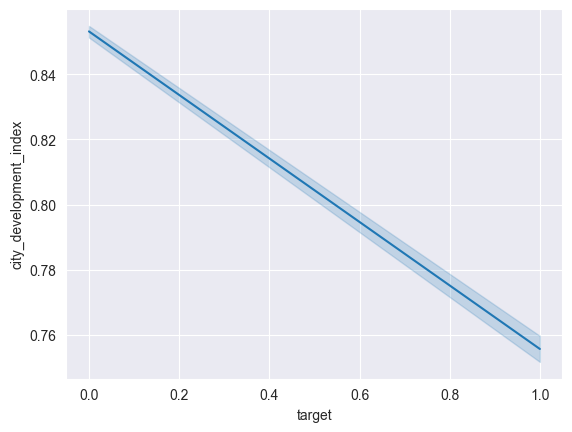

In [59]:
sns.lineplot(x='target', y='city_development_index', data=df)
plt.show()

<Axes: xlabel='training_hours', ylabel='Count'>

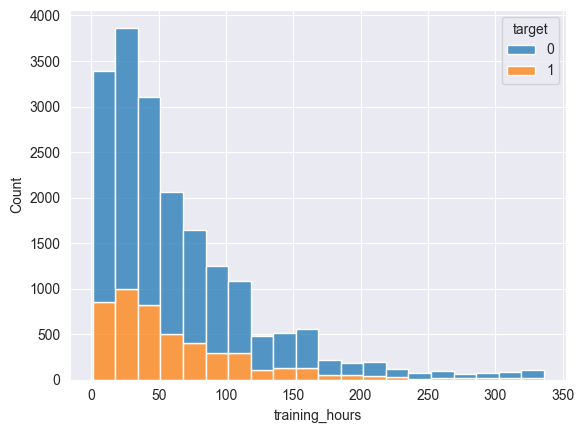

In [60]:
sns.histplot(x='training_hours', hue="target", data=df, bins=20, stat='count', multiple='stack')

From the graph, it is evident that people with City_development_index between 0.60 and 0.70 are mostly ready to change the job. It shows that if the city_development_index is higher, it is more possible to lead the target to value false. Hence, city_development_index is a good feature to train the model. Regardless of the outcome of the `target`, the distribution shows that as the value increases, the count also increases. Candidates with fewer training hours are more willing to find jobs, whereas candidates with more training hours are less inclined to find jobs.

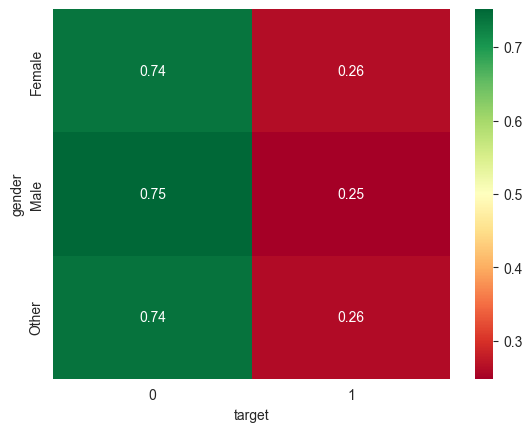

In [61]:
g = sns.heatmap(
    pd.crosstab(df['gender'], df['target']).div(pd.crosstab(df['gender'], df['target']).sum(axis=1), axis=0),
    annot=True, cmap="RdYlGn")

As we see, for different gender, the ratio of target values is similar, hence, gender seems not a good value.

### Relevant_Experience
 Has relevant experience can lead to a higher proportion of False in target feature. Hence, Has relevant experience can be a good descriptive feature. For no relevant experience, the value of experience should be 0 (Not every 0 value means no relevant experience, because we change the <1 value to 0). There must be some connection with this two attribute!


In [62]:
df['relevent_experience'].value_counts()

relevent_experience
Has relevent experience    13792
No relevent experience      5366
Name: count, dtype: int64

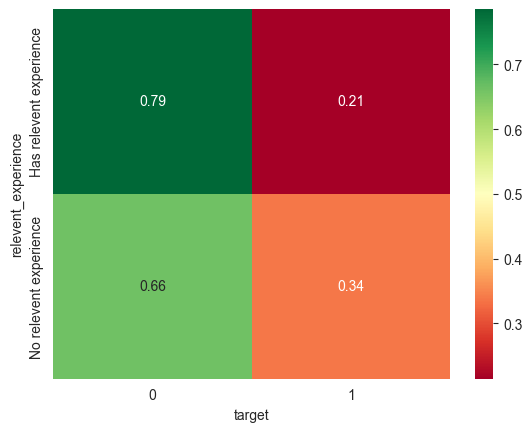

In [63]:
g = sns.heatmap(pd.crosstab(df['relevent_experience'], df['target']).div(
    pd.crosstab(df['relevent_experience'], df['target']).sum(axis=1), axis=0), annot=True, cmap="RdYlGn")

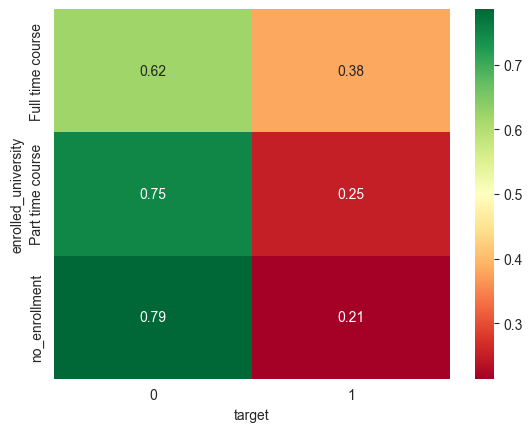

In [64]:
g = sns.heatmap(
    pd.crosstab(df['enrolled_university'], df['target']).div(
        pd.crosstab(df['enrolled_university'], df['target']).sum(axis=1), axis=0), annot=True, cmap="RdYlGn")

People who have full time course have a higher eager to change the job.

## Connection between attributes
Now we can analyze the correlation between different labels.

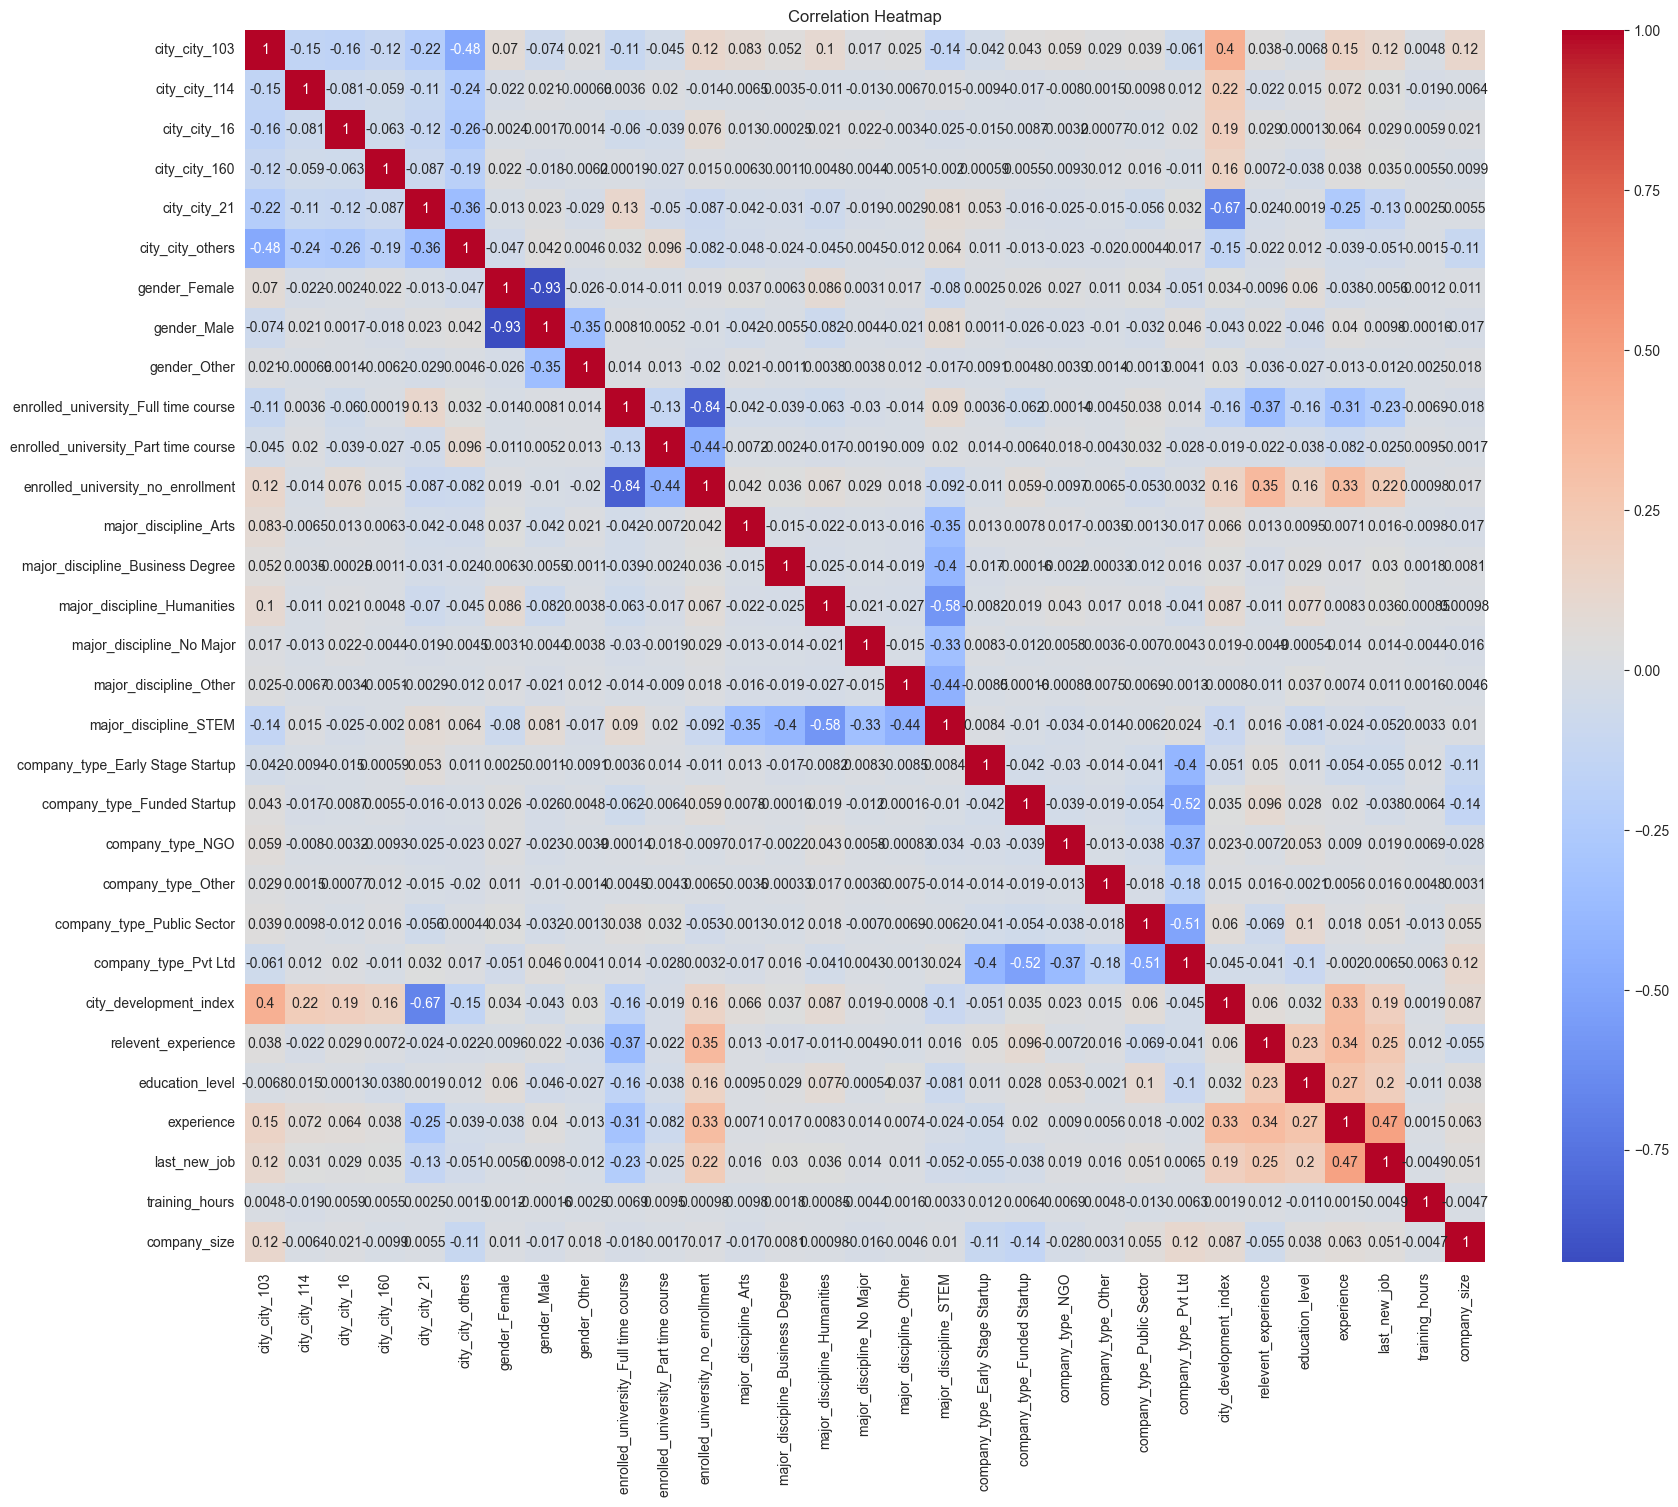

In [65]:
plt.figure(figsize=(20, 16))
sns.heatmap(concatenated_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

### From this graph, we can especially pay more attention between city_development_index and city, enrolled_university and relevant_experience, enrolled_university and experience, relevent_experience and experience, city_development_index and experience, experience and last_new_job, education_level and experience.
### This graph also shown that there is no significant relationship between the two descriptive feature, so, we don't need to discard features just because of their high similarity.
#### tips: we should focus on the continuous feature more because after one-hot encoding this graph can not show exact information.

#### City and city_development_index

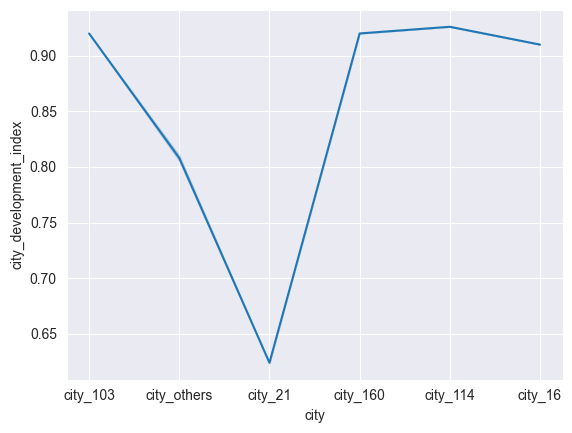

In [66]:
sns.lineplot(x='city', y='city_development_index', data=df)
plt.show()

It shows that city_21 has a significant lower city_development_index than any other cities. So that it has a higher possibility not to eager for the job chance.

#### Experience and relevent_experience

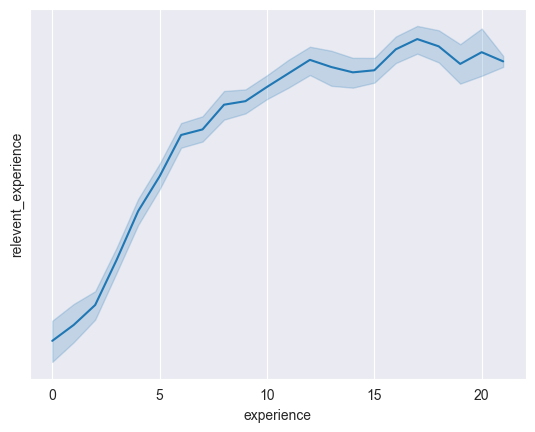

In [67]:
sns.lineplot(x='experience', y='relevent_experience', data=df)
plt.show()

When experience is 0, there are 0.3 for relevant_experience which means there are still some people have experience but less than 1 year. Another problem is that when experience is 5 years, the relevant experience is not 1. That means the people who have relevant experience might not have relevant experience.

In [68]:
df[(df['experience'] != 0) & (df['relevent_experience'] == 'No relevent experience')].count()

city                      5008
city_development_index    5008
gender                    5008
relevent_experience       5008
enrolled_university       5008
education_level           5008
major_discipline          5008
experience                5008
company_size              5008
company_type              5008
last_new_job              5008
training_hours            5008
target                    5008
dtype: int64

In [69]:
df[(df['experience'] == 0) & (df['relevent_experience'] == 'Has relevent experience')].count()

city                      164
city_development_index    164
gender                    164
relevent_experience       164
enrolled_university       164
education_level           164
major_discipline          164
experience                164
company_size              164
company_type              164
last_new_job              164
training_hours            164
target                    164
dtype: int64

#### If there are relevant experience, experience should not be 0, this is a problem appears when transferring the categorical feature to countable value. There are only 164 data have this problem, so we can change it.

In [70]:
df.loc[(df['experience'] == 0) & (df['relevent_experience'] == 'Has relevent experience'), 'experience'] = 1
df[(df['experience'] == 0) & (df['relevent_experience'] == 'Has relevent experience')].count()

city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
target                    0
dtype: int64

Now we fixed the problem.

In [71]:
correlation = df['experience'].corr(concatenated_df['relevent_experience'])
print("Correlation between experience and relevent_experience:", correlation)

Correlation between experience and relevent_experience: 0.3389440856586282


Experience and relevent_experience have some relationship but that is not high, so we can keep all of them.

#### Last_new_job and experience

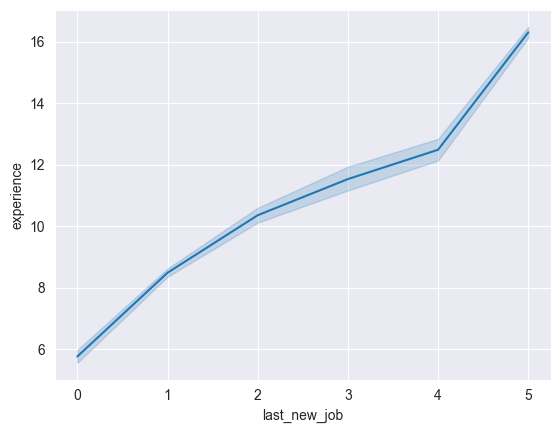

In [72]:
sns.lineplot(x='last_new_job', y='experience', data=df)
plt.show()

The relationship between last_new_job and experience is linear, people who have longer experience difference in years between previous job and current job is higher.

In [73]:
correlation = df['experience'].corr(df['last_new_job'])
print("Correlation between experience and last_new_job:", correlation)

Correlation between experience and last_new_job: 0.47440458707076577


### Enrolled_university, education_level and major_discipline are all about education. We can observe it together to try this.

#### Enrolled_university and education_level

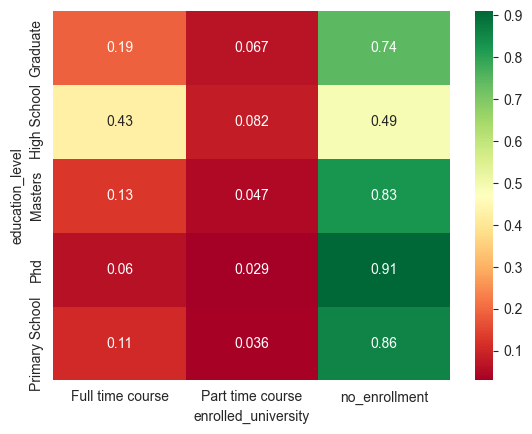

In [74]:
g = sns.heatmap(
    pd.crosstab(df['education_level'], df['enrolled_university']).div(
        pd.crosstab(df['education_level'], df['enrolled_university']).sum(axis=1), axis=0), annot=True, cmap="RdYlGn")

Candidate in full time course and no_enrollment are more likely in high school.

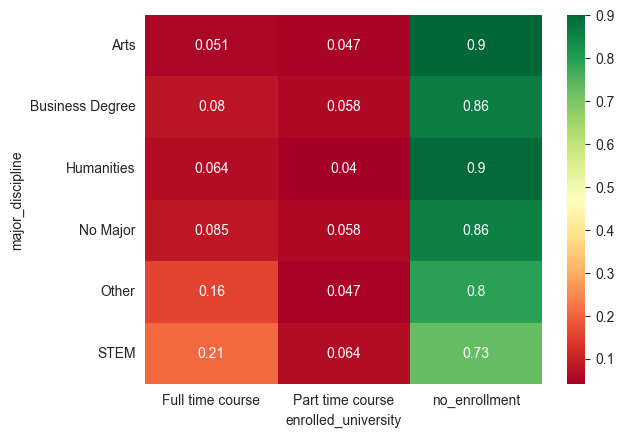

In [75]:
g = sns.heatmap(
    pd.crosstab(df['major_discipline'], df['enrolled_university']).div(
        pd.crosstab(df['major_discipline'], df['enrolled_university']).sum(axis=1), axis=0), annot=True, cmap="RdYlGn")

No significant between this two attribute, it is good for our training, because they are in the same area but no relationship.

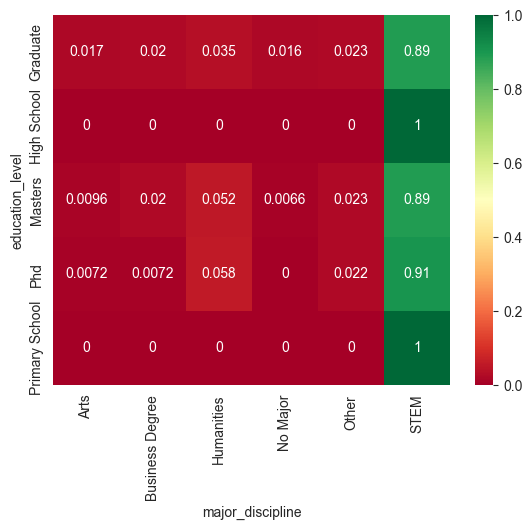

In [76]:
g = sns.heatmap(
    pd.crosstab(df['education_level'], df['major_discipline']).div(
        pd.crosstab(df['education_level'], df['major_discipline']).sum(axis=1), axis=0), annot=True, cmap="RdYlGn")

#### Company_size and company_type

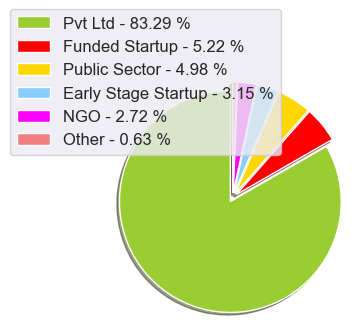

In [77]:
fig = plt.figure(figsize=(9, 3))
size_value_counts = df['company_type'].value_counts()
x = np.char.array([str(i) for i in size_value_counts.index])
y = np.array(size_value_counts.values)
colors = ['yellowgreen', 'red', 'gold', 'lightskyblue', 'magenta', 'lightcoral', 'blue', 'pink', 'darkgreen', 'yellow',
          'grey', 'violet', 'white', 'cyan'][:len(size_value_counts.index)]
explode = [0.05] * len(size_value_counts.index)
porcent = 100. * y / y.sum()

patches, texts = plt.pie(y, colors=colors, startangle=90, radius=1.2, shadow=True,
                         wedgeprops={'linewidth': 1, 'linestyle': 'solid', 'antialiased': True}, explode=explode)
labels = ['{0} - {1:1.2f} %'.format(i, j) for i, j in zip(x, porcent)]

sort_legend = True
if sort_legend: patches, labels, dummy = zip(*sorted(zip(patches, labels, y), key=lambda x: x[2], reverse=True))
plt.legend(patches, labels, loc='center left', bbox_to_anchor=(-0.5, 1.), fontsize=12)
plt.show()

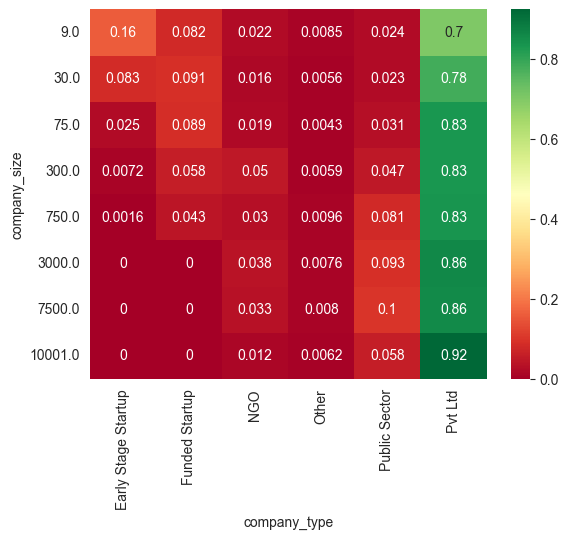

In [78]:
g = sns.heatmap(
    pd.crosstab(df['company_size'], df['company_type']).div(
        pd.crosstab(df['company_size'], df['company_type']).sum(axis=1), axis=0), annot=True, cmap="RdYlGn")

Company whose type is Pvt Ltd are more likely to have large company_size than other type. Company whose type are Early stage startup and funded startup are having the totally different trend.

# Step 4: Prediction
## Attribute Selection
After our analysis, we have determined that the 'enrollee_id' attribute can be safely removed as it does not have a significant impact on the prediction.
Now we need to choose attribute by analyzing the connection between target and features, features variance. In this section, we will use the variance threshold, univariate feature selection and RFE.

In [79]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.1)
X_selected = selector.fit_transform(concatenated_df)
selected_feature_indices = selector.get_support(indices=True)
selected_feature_names = concatenated_df.columns[selected_feature_indices]
print("Original Features:\n", concatenated_df.columns)
print("\nSelected Features:\n", selected_feature_names)

Original Features:
 Index(['city_city_103', 'city_city_114', 'city_city_16', 'city_city_160',
       'city_city_21', 'city_city_others', 'gender_Female', 'gender_Male',
       'gender_Other', 'enrolled_university_Full time course',
       'enrolled_university_Part time course',
       'enrolled_university_no_enrollment', 'major_discipline_Arts',
       'major_discipline_Business Degree', 'major_discipline_Humanities',
       'major_discipline_No Major', 'major_discipline_Other',
       'major_discipline_STEM', 'company_type_Early Stage Startup',
       'company_type_Funded Startup', 'company_type_NGO', 'company_type_Other',
       'company_type_Public Sector', 'company_type_Pvt Ltd',
       'city_development_index', 'relevent_experience', 'education_level',
       'experience', 'last_new_job', 'training_hours', 'company_size'],
      dtype='object')

Selected Features:
 Index(['city_city_103', 'city_city_21', 'city_city_others',
       'enrolled_university_Full time course',
       'en

In [80]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

selector = SelectKBest(score_func=f_classif, k=5)
X_selected = selector.fit_transform(concatenated_df, df['target'])
selected_feature_indices = selector.get_support(indices=True)
selected_feature_names = concatenated_df.columns[selected_feature_indices]
print("Original Features:\n", concatenated_df.columns)
print("\nSelected Features:\n", selected_feature_names)

Original Features:
 Index(['city_city_103', 'city_city_114', 'city_city_16', 'city_city_160',
       'city_city_21', 'city_city_others', 'gender_Female', 'gender_Male',
       'gender_Other', 'enrolled_university_Full time course',
       'enrolled_university_Part time course',
       'enrolled_university_no_enrollment', 'major_discipline_Arts',
       'major_discipline_Business Degree', 'major_discipline_Humanities',
       'major_discipline_No Major', 'major_discipline_Other',
       'major_discipline_STEM', 'company_type_Early Stage Startup',
       'company_type_Funded Startup', 'company_type_NGO', 'company_type_Other',
       'company_type_Public Sector', 'company_type_Pvt Ltd',
       'city_development_index', 'relevent_experience', 'education_level',
       'experience', 'last_new_job', 'training_hours', 'company_size'],
      dtype='object')

Selected Features:
 Index(['city_city_21', 'enrolled_university_Full time course',
       'enrolled_university_no_enrollment', 'city_deve

In [81]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

estimator = LogisticRegression()
selector = RFE(estimator, n_features_to_select=5)
X_selected = selector.fit_transform(concatenated_df, df['target'])
selected_feature_indices = selector.get_support(indices=True)
selected_feature_names = concatenated_df.columns[selected_feature_indices]
print("Original Features:\n", concatenated_df.columns)
print("\nSelected Features:\n", selected_feature_names)

Original Features:
 Index(['city_city_103', 'city_city_114', 'city_city_16', 'city_city_160',
       'city_city_21', 'city_city_others', 'gender_Female', 'gender_Male',
       'gender_Other', 'enrolled_university_Full time course',
       'enrolled_university_Part time course',
       'enrolled_university_no_enrollment', 'major_discipline_Arts',
       'major_discipline_Business Degree', 'major_discipline_Humanities',
       'major_discipline_No Major', 'major_discipline_Other',
       'major_discipline_STEM', 'company_type_Early Stage Startup',
       'company_type_Funded Startup', 'company_type_NGO', 'company_type_Other',
       'company_type_Public Sector', 'company_type_Pvt Ltd',
       'city_development_index', 'relevent_experience', 'education_level',
       'experience', 'last_new_job', 'training_hours', 'company_size'],
      dtype='object')

Selected Features:
 Index(['city_city_114', 'city_city_16', 'city_city_others',
       'city_development_index', 'relevent_experience'],


### Now we get our final feature, which is city, enrolled_university, company_type, city_development_index, relevent_experience, education_level, experience, last_new_job, training_hours, company_size. Now we can get our training feature.

In [82]:
columns_to_drop = [
    'gender_Male', 'gender_Other', 'gender_Female',
    'major_discipline_Other', 'major_discipline_No Major', 'major_discipline_STEM',
    'major_discipline_Humanities', 'major_discipline_Arts', 'major_discipline_Business Degree',
    'education_level'
]
concatenated_df = concatenated_df.drop(columns=columns_to_drop)
concatenated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 21 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   city_city_103                         19158 non-null  int64  
 1   city_city_114                         19158 non-null  int64  
 2   city_city_16                          19158 non-null  int64  
 3   city_city_160                         19158 non-null  int64  
 4   city_city_21                          19158 non-null  int64  
 5   city_city_others                      19158 non-null  int64  
 6   enrolled_university_Full time course  19158 non-null  int64  
 7   enrolled_university_Part time course  19158 non-null  int64  
 8   enrolled_university_no_enrollment     19158 non-null  int64  
 9   company_type_Early Stage Startup      19158 non-null  int64  
 10  company_type_Funded Startup           19158 non-null  int64  
 11  company_type_NG

## Get the training set.
We will split our set into two categories: 6:2:2 and 8:1:1

In [83]:
# add the descriptive set and target set
x = concatenated_df
y = df['target']
# train: validation: test = 6:2:2
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(x, y, test_size=0.4)
x_test_1, x_validation_1, y_test_1, y_validation_1 = train_test_split(x_test_1, y_test_1, test_size=0.5)
# Split the dataset into 8:1:1
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(x, y, test_size=0.2)
x_test_2, x_validation_2, y_test_2, y_validation_2 = train_test_split(x_test_2, y_test_2, test_size=0.5)

## 1. Decision Tree
A decision tree is a supervised machine learning model that represents a tree-like structure for solving classification and regression problems. It recursively partitions the input dataset based on the optimal features, aiming to maximize purity or minimize impurity in each subset. Each non-leaf node corresponds to a feature test, and each branch represents a possible outcome. Terminal nodes (leaves) store the final output labels or values. Decision trees are known for their interpretability and visual appeal, yet may suffer from overfitting. Techniques like pruning help control complexity. Here, we change the hyperparametes of criterion and max_depth and compare them to find a better parameter.

In [84]:
print('Decision Tree split as 6:2:2')
# Max_depth is set to 4 with gini
classifier = DecisionTreeClassifier(criterion='gini', max_depth=4)
classifier.fit(x_train_1, y_train_1)
y_pred0 = classifier.predict(x_validation_1)
accuracy_tree = []
f1_tree = []
acc = metrics.accuracy_score(y_validation_1, y_pred0)
accuracy_tree.append(acc)
f1_score = metrics.f1_score(y_validation_1, y_pred0)
f1_tree.append(f1_score)
print("->Gini & depth 4")
print("Accuracy: ", acc)
print(metrics.classification_report(y_pred=y_pred0, y_true=y_validation_1))
auc0 = metrics.roc_auc_score(y_validation_1, y_pred0)
pd.DataFrame(y_validation_1).count()
fpr0, tpr0, _ = metrics.roc_curve(y_validation_1, y_pred0)
print("-----------------------------------------------------")
# Max_depth is set to 8 with gini
classifier = DecisionTreeClassifier(criterion='gini', max_depth=9)
classifier.fit(x_train_1, y_train_1)
y_pred1 = classifier.predict(x_validation_1)
acc = metrics.accuracy_score(y_validation_1, y_pred1)
accuracy_tree.append(acc)
f1_score = metrics.f1_score(y_validation_1, y_pred1)
f1_tree.append(f1_score)
print("\n->Gini & depth 9")
print("Accuracy: ", acc)
print(metrics.classification_report(y_pred=y_pred1, y_true=y_validation_1))
auc1 = metrics.roc_auc_score(y_validation_1, y_pred1)
fpr1, tpr1, _ = metrics.roc_curve(y_validation_1, y_pred1)
print("-----------------------------------------------------")
# Max_depth is set to 4 with entropy
classifier = DecisionTreeClassifier(criterion='entropy', max_depth=4)
classifier.fit(x_train_1, y_train_1)
y_pred2 = classifier.predict(x_validation_1)
acc = metrics.accuracy_score(y_validation_1, y_pred2)
accuracy_tree.append(acc)
f1_score = metrics.f1_score(y_validation_1, y_pred2)
f1_tree.append(f1_score)
print("\n->Entropy & depth 4")
print("Accuracy: ", acc)
print(metrics.classification_report(y_pred=y_pred2, y_true=y_validation_1))
auc2 = metrics.roc_auc_score(y_validation_1, y_pred2)
fpr2, tpr2, _ = metrics.roc_curve(y_validation_1, y_pred2)

print("-----------------------------------------------------")
# Max_depth is set to 8 with entropy
classifier = DecisionTreeClassifier(criterion='entropy', max_depth=9)
classifier.fit(x_train_1, y_train_1)
y_pred3 = classifier.predict(x_validation_1)
acc = metrics.accuracy_score(y_validation_1, y_pred3)
accuracy_tree.append(acc)
f1_score = metrics.f1_score(y_validation_1, y_pred3)
f1_tree.append(f1_score)
print("\n->Entropy & depth 9")
print("Accuracy: ", acc)
print(metrics.classification_report(y_pred=y_pred3, y_true=y_validation_1))
auc3 = metrics.roc_auc_score(y_validation_1, y_pred3)
fpr3, tpr3, _ = metrics.roc_curve(y_validation_1, y_pred3)
print("～～～～～～～～～～～～～～～～～～～～～～～～～～～～～～～～")
print("～～～～～～～～～～～～～～～～～～～～～～～～～～～～～～～～")
print('\nDecision Tree split as 8:1:1')

# Max_depth is set to 4 with gini
classifier = DecisionTreeClassifier(criterion='gini', max_depth=4)
classifier.fit(x_train_2, y_train_2)
y_pred4 = classifier.predict(x_validation_2)
acc = metrics.accuracy_score(y_validation_2, y_pred4)
accuracy_tree.append(acc)
f1_score = metrics.f1_score(y_validation_2, y_pred4)
f1_tree.append(f1_score)
print("\n->Gini & depth 4")
print("Accuracy: ", acc)
print(metrics.classification_report(y_pred=y_pred4, y_true=y_validation_2))
auc4 = metrics.roc_auc_score(y_validation_2, y_pred4)
fpr4, tpr4, _ = metrics.roc_curve(y_validation_2, y_pred4)
print("-----------------------------------------------------")
# Max_depth is set to 8 with gini
classifier = DecisionTreeClassifier(criterion='gini', max_depth=9)
classifier.fit(x_train_2, y_train_2)
y_pred5 = classifier.predict(x_validation_2)
acc = metrics.accuracy_score(y_validation_2, y_pred5)
accuracy_tree.append(acc)
f1_score = metrics.f1_score(y_validation_2, y_pred5)
f1_tree.append(f1_score)
print("\n->Gini & depth 9")
print("Accuracy: ", acc)
print(metrics.classification_report(y_pred=y_pred5, y_true=y_validation_2))
auc5 = metrics.roc_auc_score(y_validation_2, y_pred5)
fpr5, tpr5, _ = metrics.roc_curve(y_validation_2, y_pred5)
print("-----------------------------------------------------")
# Max_depth is set to 4 with entropy
classifier = DecisionTreeClassifier(criterion='entropy', max_depth=4)
classifier.fit(x_train_2, y_train_2)
y_pred6 = classifier.predict(x_validation_2)
acc = metrics.accuracy_score(y_validation_2, y_pred6)
accuracy_tree.append(acc)
f1_score = metrics.f1_score(y_validation_2, y_pred6)
f1_tree.append(f1_score)
print("\n->Entropy & depth 4")
print("Accuracy: ", acc)
print(metrics.classification_report(y_pred=y_pred6, y_true=y_validation_2))
auc6 = metrics.roc_auc_score(y_validation_2, y_pred6)
fpr6, tpr6, _ = metrics.roc_curve(y_validation_2, y_pred6)
print("-----------------------------------------------------")
# Max_depth is set to 8 with entropy
classifier = DecisionTreeClassifier(criterion='entropy', max_depth=9)
classifier.fit(x_train_2, y_train_2)
y_pred7 = classifier.predict(x_validation_2)
acc = metrics.accuracy_score(y_validation_2, y_pred7)
accuracy_tree.append(acc)
f1_score = metrics.f1_score(y_validation_2, y_pred7)
f1_tree.append(f1_score)
print("\n->Entropy & depth 9")
print("Accuracy: ", acc)
print(metrics.classification_report(y_pred=y_pred7, y_true=y_validation_2))
auc7 = metrics.roc_auc_score(y_validation_2, y_pred7)
fpr7, tpr7, _ = metrics.roc_curve(y_validation_2, y_pred7)
acc_dt = sum(accuracy_tree) / 8
accuracy_ave = [acc_dt]
f1_dt = sum(f1_tree) / 8
f1_ave = [f1_dt]
models = ['Decision Tree']
print("The average accuracy of Decision Tree is:", acc_dt)
print("The average f1 score of Decision Tree is:", f1_dt)

Decision Tree split as 6:2:2
->Gini & depth 4
Accuracy:  0.778705636743215
              precision    recall  f1-score   support

           0       0.81      0.91      0.86      2820
           1       0.62      0.42      0.50      1012

    accuracy                           0.78      3832
   macro avg       0.72      0.66      0.68      3832
weighted avg       0.76      0.78      0.76      3832

-----------------------------------------------------

->Gini & depth 9
Accuracy:  0.7685281837160751
              precision    recall  f1-score   support

           0       0.80      0.90      0.85      2820
           1       0.59      0.39      0.47      1012

    accuracy                           0.77      3832
   macro avg       0.70      0.65      0.66      3832
weighted avg       0.75      0.77      0.75      3832

-----------------------------------------------------

->Entropy & depth 4
Accuracy:  0.7719206680584552
              precision    recall  f1-score   support

         

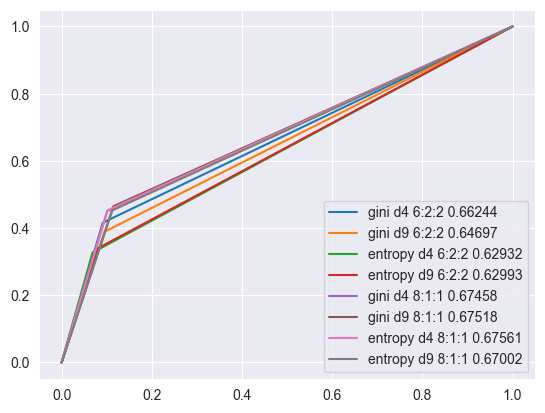

In [85]:
plt.plot(fpr0, tpr0, label="gini d4 6:2:2 " + "{:.5f}".format(auc0))
plt.plot(fpr1, tpr1, label="gini d9 6:2:2 " + "{:.5f}".format(auc1))
plt.plot(fpr2, tpr2, label="entropy d4 6:2:2 " + "{:.5f}".format(auc2))
plt.plot(fpr3, tpr3, label="entropy d9 6:2:2 " + "{:.5f}".format(auc3))

plt.plot(fpr4, tpr4, label="gini d4 8:1:1 " + "{:.5f}".format(auc4))
plt.plot(fpr5, tpr5, label="gini d9 8:1:1 " + "{:.5f}".format(auc5))
plt.plot(fpr6, tpr6, label="entropy d4 8:1:1 " + "{:.5f}".format(auc6))
plt.plot(fpr7, tpr7, label="entropy d9 8:1:1 " + "{:.5f}".format(auc7))

plt.legend(loc=4)
plt.show()

Text(0, 0.5, 'Accuracy')

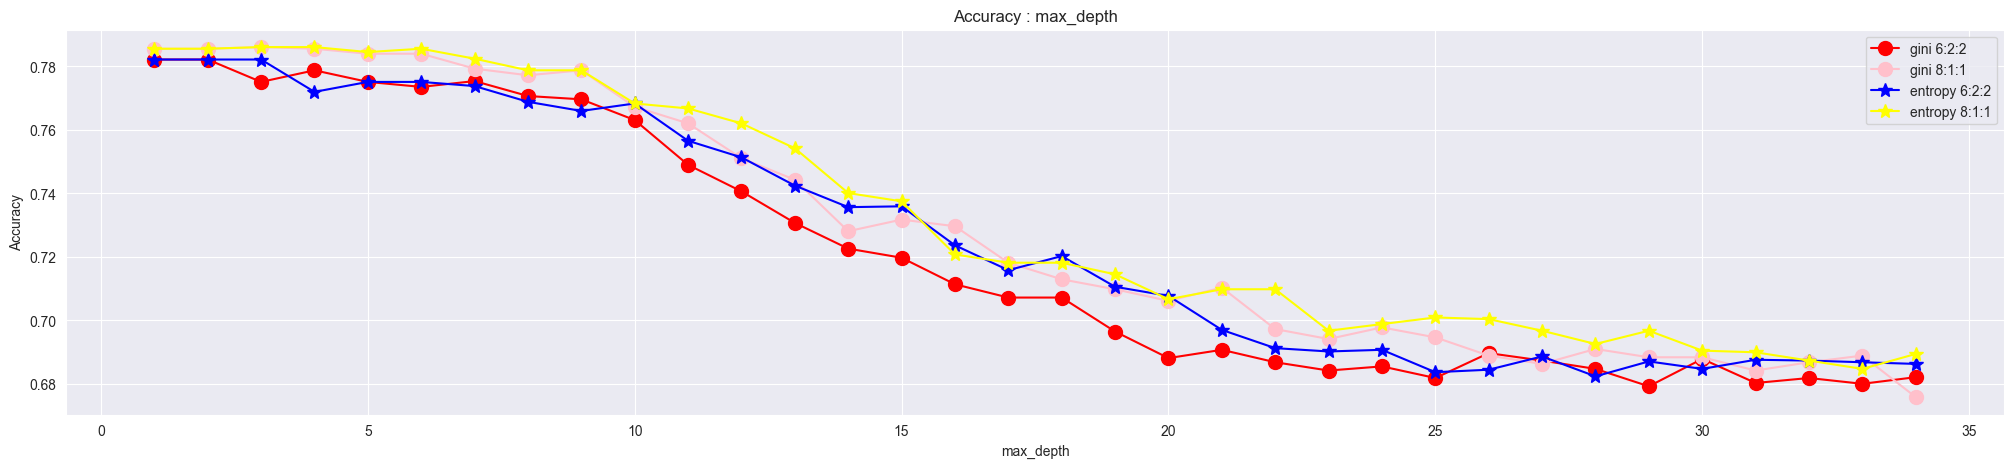

In [86]:
accuracy_gini_1 = []
accuracy_gini_2 = []
accuracy_entropy_1 = []
accuracy_entropy_2 = []
for i in range(1, 35):
    classifier_gini = DecisionTreeClassifier(criterion='gini', max_depth=i)
    classifier_gini.fit(x_train_1, y_train_1)
    y_pred_gini = classifier_gini.predict(x_validation_1)
    acc_gini = metrics.accuracy_score(y_validation_1, y_pred_gini)
    accuracy_gini_1.append(acc_gini)

    classifier_entropy = DecisionTreeClassifier(criterion='entropy', max_depth=i)
    classifier_entropy.fit(x_train_1, y_train_1)
    y_pred_entropy = classifier_entropy.predict(x_validation_1)
    acc_entropy = metrics.accuracy_score(y_validation_1, y_pred_entropy)
    accuracy_entropy_1.append(acc_entropy)

for i in range(1, 35):
    classifier_gini = DecisionTreeClassifier(criterion='gini', max_depth=i)
    classifier_gini.fit(x_train_2, y_train_2)
    y_pred_gini = classifier_gini.predict(x_validation_2)
    acc_gini = metrics.accuracy_score(y_validation_2, y_pred_gini)
    accuracy_gini_2.append(acc_gini)

    classifier_entropy = DecisionTreeClassifier(criterion='entropy', max_depth=i)
    classifier_entropy.fit(x_train_2, y_train_2)
    y_pred_entropy = classifier_entropy.predict(x_validation_2)
    acc_entropy = metrics.accuracy_score(y_validation_2, y_pred_entropy)
    accuracy_entropy_2.append(acc_entropy)

plt.figure(figsize=(25, 5))
plt.plot(range(1, 35), accuracy_gini_1, color='red', marker='o', markersize=10, label="gini 6:2:2")
plt.plot(range(1, 35), accuracy_gini_2, color='pink', marker='o', markersize=10, label="gini 8:1:1")
plt.plot(range(1, 35), accuracy_entropy_1, color='blue', marker='*', markersize=10, label="entropy 6:2:2")
plt.plot(range(1, 35), accuracy_entropy_2, color='yellow', marker='*', markersize=10, label="entropy 8:1:1")
plt.legend()
plt.title('Accuracy : max_depth')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

According to the diagram, entropy has better performance then gini, and the max_depth smaller than 5 have the higher score than larger max_depth.

## 2. KNN
KNN (K-Nearest Neighbors) is a simple and intuitive supervised learning algorithm with several key characteristics. It is non-parametric, making it flexible across various data types without relying on distribution assumptions. Being instance-based, KNN memorizes the entire training dataset rather than constructing a model. It is suitable for multi-class problems and exhibits resilience to outliers. Its decision boundaries adapt to complex shapes, making it applicable to non-linear problems. Notably, KNN requires tuning the k hyperparameter and is computationally intensive, especially for extensive datasets.

In [87]:
print("KNN split as 6:2:2")
print('\n->N_neighbors = 15')
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(x_train_1, y_train_1)
y_pred0 = knn.predict(x_validation_1)
accuracy_knn = []
f1_knn = []
acc0 = metrics.accuracy_score(y_validation_1, y_pred0)
accuracy_knn.append(acc0)
f1_score = metrics.f1_score(y_validation_1, y_pred0)
f1_knn.append(f1_score)
print("Accuracy: ", acc0)
print(metrics.classification_report(y_pred=y_pred0, y_true=y_validation_1))
auc0 = metrics.roc_auc_score(y_validation_1, y_pred0)
fpr0, tpr0, _ = metrics.roc_curve(y_validation_1, y_pred0)
print("----------------------------------------------------")
print('\n->N_neighbors = 50')
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(x_train_1, y_train_1)
y_pred2 = knn.predict(x_validation_1)
acc2 = metrics.accuracy_score(y_validation_1, y_pred2)
accuracy_knn.append(acc2)
f1_score = metrics.f1_score(y_validation_1, y_pred2)
f1_knn.append(f1_score)
print("Accuracy: ", acc2)
print(metrics.classification_report(y_pred=y_pred2, y_true=y_validation_1))
auc2 = metrics.roc_auc_score(y_validation_1, y_pred2)
fpr2, tpr2, _ = metrics.roc_curve(y_validation_1, y_pred2)

print("～～～～～～～～～～～～～～～～～～～～～～～～～～～～～～～～")
print("～～～～～～～～～～～～～～～～～～～～～～～～～～～～～～～～")
print("\n\nKNN split as 8:1:1")
print('\n->N_neighbors = 15')

knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(x_train_2, y_train_2)
y_pred1 = knn.predict(x_validation_2)
acc1 = metrics.accuracy_score(y_validation_2, y_pred1)
accuracy_knn.append(acc1)
f1_score = metrics.f1_score(y_validation_2, y_pred1)
f1_knn.append(f1_score)
print("Accuracy: ", acc1)
print(metrics.classification_report(y_pred=y_pred1, y_true=y_validation_2))
auc1 = metrics.roc_auc_score(y_validation_2, y_pred1)
fpr1, tpr1, _ = metrics.roc_curve(y_validation_2, y_pred1)

print("----------------------------------------------------")
print('\n->N_neighbors = 50')

knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(x_train_2, y_train_2)
y_pred3 = knn.predict(x_validation_2)
acc3 = metrics.accuracy_score(y_validation_2, y_pred3)
accuracy_knn.append(acc3)
f1_score = metrics.f1_score(y_validation_2, y_pred3)
f1_knn.append(f1_score)
print("Accuracy: ", acc3)
print(metrics.classification_report(y_pred=y_pred3, y_true=y_validation_2))
auc3 = metrics.roc_auc_score(y_validation_2, y_pred3)
fpr3, tpr3, _ = metrics.roc_curve(y_validation_2, y_pred3)

acc_knn = sum(accuracy_knn) / 4
f1_k = sum(f1_knn) / 4
accuracy_ave.append(acc_knn)
f1_ave.append(f1_k)
models.append('KNN')
print("The average of KNN accuracy is:", acc_knn)
print("The average of KNN f1 score is:", f1_k)

KNN split as 6:2:2

->N_neighbors = 15
Accuracy:  0.7737473903966597
              precision    recall  f1-score   support

           0       0.80      0.92      0.86      2820
           1       0.62      0.36      0.46      1012

    accuracy                           0.77      3832
   macro avg       0.71      0.64      0.66      3832
weighted avg       0.75      0.77      0.75      3832

----------------------------------------------------

->N_neighbors = 50
Accuracy:  0.7784446764091858
              precision    recall  f1-score   support

           0       0.80      0.93      0.86      2820
           1       0.64      0.36      0.47      1012

    accuracy                           0.78      3832
   macro avg       0.72      0.65      0.66      3832
weighted avg       0.76      0.78      0.76      3832

～～～～～～～～～～～～～～～～～～～～～～～～～～～～～～～～
～～～～～～～～～～～～～～～～～～～～～～～～～～～～～～～～


KNN split as 8:1:1

->N_neighbors = 15
Accuracy:  0.7693110647181628
              precision    recall  f1

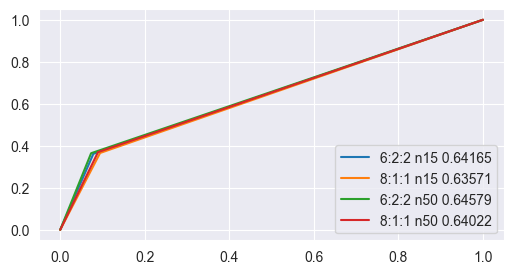

In [88]:
plt.figure(figsize=(6, 3))
plt.plot(fpr0, tpr0, label="6:2:2 n15 " + "{:.5f}".format(auc0))
plt.plot(fpr1, tpr1, label="8:1:1 n15 " + "{:.5f}".format(auc1))
plt.plot(fpr2, tpr2, label="6:2:2 n50 " + "{:.5f}".format(auc2))
plt.plot(fpr3, tpr3, label="8:1:1 n50 " + "{:.5f}".format(auc3))

plt.legend(loc=4)
plt.show()

Text(0, 0.5, 'Accuracy')

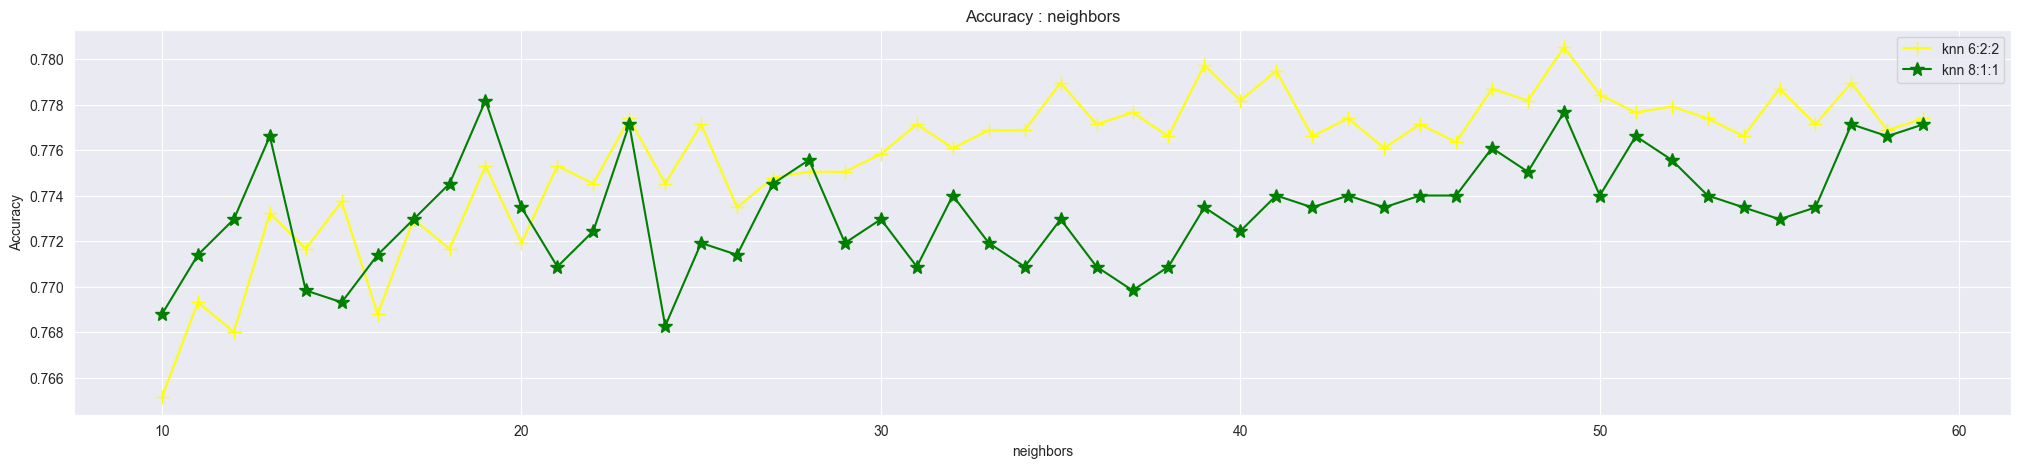

In [89]:
accuracy_knn_1 = []
accuracy_knn_2 = []
for i in range(10, 60):
    classifier_knn = KNeighborsClassifier(n_neighbors=i)
    classifier_knn.fit(x_train_1, y_train_1)
    y_pred_knn = classifier_knn.predict(x_validation_1)
    acc_knn = metrics.accuracy_score(y_validation_1, y_pred_knn)
    accuracy_knn_1.append(acc_knn)
for i in range(10, 60):
    classifier_knn = KNeighborsClassifier(n_neighbors=i)
    classifier_knn.fit(x_train_2, y_train_2)
    y_pred_knn = classifier_knn.predict(x_validation_2)
    acc_knn = metrics.accuracy_score(y_validation_2, y_pred_knn)
    accuracy_knn_2.append(acc_knn)

plt.figure(figsize=(25, 5))
plt.plot(range(10, 60), accuracy_knn_1, color='yellow', marker='+', markersize=10, label="knn 6:2:2")
plt.plot(range(10, 60), accuracy_knn_2, color='green', marker='*', markersize=10, label="knn 8:1:1")
plt.legend()
plt.title('Accuracy : neighbors')
plt.xlabel('neighbors')
plt.ylabel('Accuracy')

For KNN, the grouping of 8:1:1 demonstrates better performance, with fewer neighbors (8:1:1) yielding superior results. Conversely, in the case of 6:2:2, where more neighbors are considered, the performance is enhanced. The choice of the grouping ratio has a notable impact on the algorithm's effectiveness, highlighting the importance of the balance between the number of neighbors and the dataset proportions. After analysis, we will choose the k = 43.

## 3. Naive Bayes
Naive Bayes is a probabilistic machine learning algorithm based on Bayes' theorem. It is characterized by its simplicity and effectiveness in classification tasks. The "naive" assumption assumes independence between features, simplifying computations. It is widely used in natural language processing and spam filtering. Naive Bayes calculates the probability of each class given the input features, selecting the class with the highest probability as the predicted outcome. Despite its simplicity, Naive Bayes often performs well, especially in text classification and situations where feature independence is a reasonable assumption. It's computationally efficient and suitable for handling large datasets.

In [90]:
print('Naive Bayes in 6:2:2')
print('\n->BernoulliNB')
ber_nb = BernoulliNB()
ber_nb.fit(x_train_1, y_train_1)
y_pred0 = ber_nb.predict(x_validation_1)
accuracy_ber_nb = []
f1_ber_nb = []
f1_gau_nb = []
acc0 = metrics.accuracy_score(y_validation_1, y_pred0)
accuracy_ber_nb.append(acc0)
f1_score = metrics.f1_score(y_validation_1, y_pred0)
f1_ber_nb.append(f1_score)
print("Accuracy: ", acc0)
print(metrics.classification_report(y_pred=y_pred0, y_true=y_validation_1))
auc0 = metrics.roc_auc_score(y_validation_1, y_pred0)
fpr0, tpr0, _ = metrics.roc_curve(y_validation_1, y_pred0)

print("----------------------------------------------------")
print('\n->GaussianNB')

gau_nb = GaussianNB()
gau_nb.fit(x_train_1, y_train_1)
y_pred2 = gau_nb.predict(x_validation_1)

accuracy_gau_nb = []
acc2 = metrics.accuracy_score(y_validation_1, y_pred2)
accuracy_gau_nb.append(acc2)
f1_score = metrics.f1_score(y_validation_1, y_pred2)
f1_gau_nb.append(f1_score)
print("Accuracy: ", acc2)
print(metrics.classification_report(y_pred=y_pred2, y_true=y_validation_1))

auc2 = metrics.roc_auc_score(y_validation_1, y_pred2)
fpr2, tpr2, _ = metrics.roc_curve(y_validation_1, y_pred2)
print("～～～～～～～～～～～～～～～～～～～～～～～～～～～～～～～～")
print("～～～～～～～～～～～～～～～～～～～～～～～～～～～～～～～～")
print('\n\nNaive Bayes  8:1:1')
print('\n->BernoulliNB')

ber_nb = BernoulliNB()
ber_nb.fit(x_train_2, y_train_2)
y_pred1 = ber_nb.predict(x_validation_2)

acc1 = metrics.accuracy_score(y_validation_2, y_pred1)
accuracy_ber_nb.append(acc1)
f1_score = metrics.f1_score(y_validation_2, y_pred1)
f1_ber_nb.append(f1_score)
print("Accuracy: ", acc1)
print(metrics.classification_report(y_pred=y_pred1, y_true=y_validation_2))

auc1 = metrics.roc_auc_score(y_validation_2, y_pred1)
fpr1, tpr1, _ = metrics.roc_curve(y_validation_2, y_pred1)

print("----------------------------------------------------")
print('\n->GaussianNB')

gau_nb = GaussianNB()
gau_nb.fit(x_train_2, y_train_2)
y_pred3 = gau_nb.predict(x_validation_2)

acc3 = metrics.accuracy_score(y_validation_2, y_pred3)
accuracy_gau_nb.append(acc3)
f1_score = metrics.f1_score(y_validation_2, y_pred3)
f1_gau_nb.append(f1_score)
print("Accuracy: ", acc3)
print(metrics.classification_report(y_pred=y_pred3, y_true=y_validation_2))

auc3 = metrics.roc_auc_score(y_validation_2, y_pred3)
fpr3, tpr3, _ = metrics.roc_curve(y_validation_2, y_pred3)

acc_nb = (sum(accuracy_gau_nb) + sum(accuracy_ber_nb)) / 4
f1_nb = (sum(f1_gau_nb) + sum(f1_ber_nb)) / 4
accuracy_ave.append(acc_nb)
f1_ave.append(f1_nb)
models.append('Naive Bayes')
print("The average of Naive Bayes accuracy is:", acc_nb)
print("The average of Naive Bayes f1 score is:", f1_nb)

Naive Bayes in 6:2:2

->BernoulliNB
Accuracy:  0.7502609603340292
              precision    recall  f1-score   support

           0       0.81      0.87      0.84      2820
           1       0.53      0.42      0.47      1012

    accuracy                           0.75      3832
   macro avg       0.67      0.64      0.65      3832
weighted avg       0.73      0.75      0.74      3832

----------------------------------------------------

->GaussianNB
Accuracy:  0.7319937369519833
              precision    recall  f1-score   support

           0       0.83      0.79      0.81      2820
           1       0.49      0.56      0.53      1012

    accuracy                           0.73      3832
   macro avg       0.66      0.68      0.67      3832
weighted avg       0.74      0.73      0.74      3832

～～～～～～～～～～～～～～～～～～～～～～～～～～～～～～～～
～～～～～～～～～～～～～～～～～～～～～～～～～～～～～～～～


Naive Bayes  8:1:1

->BernoulliNB
Accuracy:  0.7630480167014614
              precision    recall  f1-score   suppo

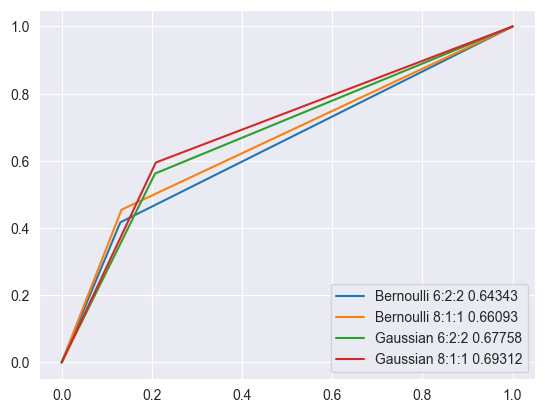

In [91]:
#draw the plot to show the difference of the auc curve
plt.plot(fpr0, tpr0, label="Bernoulli 6:2:2 " + "{:.5f}".format(auc0))
plt.plot(fpr1, tpr1, label="Bernoulli 8:1:1 " + "{:.5f}".format(auc1))
plt.plot(fpr2, tpr2, label="Gaussian 6:2:2 " + "{:.5f}".format(auc2))
plt.plot(fpr3, tpr3, label="Gaussian 8:1:1 " + "{:.5f}".format(auc3))

plt.legend(loc=4)
plt.show()

BernoulliNB has a better performance than GaussianNB

## 4. Bagging Logistic regression
Bagging Logistic Regression involves applying the bagging (bootstrap aggregating) technique to logistic regression models. It enhances model robustness and accuracy by combining multiple logistic regression predictions through resampling.

In [92]:
print('Bagging Logistic 6:2:2')
print("\nMax iteration = 4000")

base_log_reg = LogisticRegression(max_iter=4000)
bag = BaggingClassifier(estimator=base_log_reg, n_estimators=10)  #Use bagging based on logistic regression
bag.fit(x_train_1, y_train_1)
y_pred0 = bag.predict(x_validation_1)
accuracy_blr = []
f1_blr = []
acc0 = metrics.accuracy_score(y_validation_1, y_pred0)
accuracy_blr.append(acc0)
f1_score = metrics.f1_score(y_validation_1, y_pred0)
f1_blr.append(f1_score)
print("Accuracy: ", acc0)
print(metrics.classification_report(y_pred=y_pred0, y_true=y_validation_1))
auc0 = metrics.roc_auc_score(y_validation_1, y_pred0)
fpr0, tpr0, _ = metrics.roc_curve(y_validation_1, y_pred0)

print('\nMax iteration = 2000')

base_log_reg = LogisticRegression(max_iter=2000)
bag = BaggingClassifier(estimator=base_log_reg, n_estimators=10)
bag.fit(x_train_1, y_train_1)
y_pred2 = bag.predict(x_validation_1)
acc2 = metrics.accuracy_score(y_validation_1, y_pred2)
accuracy_blr.append(acc2)
f1_score = metrics.f1_score(y_validation_1, y_pred2)
f1_blr.append(f1_score)
print("Accuracy: ", acc2)
print(metrics.classification_report(y_pred=y_pred2, y_true=y_validation_1))
auc2 = metrics.roc_auc_score(y_validation_1, y_pred2)
fpr2, tpr2, _ = metrics.roc_curve(y_validation_1, y_pred2)

print("～～～～～～～～～～～～～～～～～～～～～～～～～～～～～～～～")
print("～～～～～～～～～～～～～～～～～～～～～～～～～～～～～～～～")
print('\n\nBagging Logistic 8:1:1')
print('\nMax iteration = 4000')

base_log_reg = LogisticRegression(max_iter=4000)
bag = BaggingClassifier(estimator=base_log_reg, n_estimators=10)
bag.fit(x_train_2, y_train_2)
y_pred1 = bag.predict(x_validation_2)
acc1 = metrics.accuracy_score(y_validation_2, y_pred1)
accuracy_blr.append(acc1)
f1_score = metrics.f1_score(y_validation_2, y_pred1)
f1_blr.append(f1_score)
print("Accuracy: ", acc1)
print(metrics.classification_report(y_pred=y_pred1, y_true=y_validation_2))
auc1 = metrics.roc_auc_score(y_validation_2, y_pred1)
fpr1, tpr1, _ = metrics.roc_curve(y_validation_2, y_pred1)

print("----------------------------------------------------")
print('\nMax iteration = 2000')

base_log_reg = LogisticRegression(max_iter=2000)
bag = BaggingClassifier(estimator=base_log_reg, n_estimators=10)
bag.fit(x_train_2, y_train_2)
y_pred3 = bag.predict(x_validation_2)
acc3 = metrics.accuracy_score(y_validation_2, y_pred3)
accuracy_blr.append(acc3)
f1_score = metrics.f1_score(y_validation_2, y_pred3)
f1_blr.append(f1_score)
print("Accuracy: ", acc3)
print(metrics.classification_report(y_pred=y_pred3, y_true=y_validation_2))
auc3 = metrics.roc_auc_score(y_validation_2, y_pred3)
fpr3, tpr3, _ = metrics.roc_curve(y_validation_2, y_pred3)

acc_blr = sum(accuracy_blr) / 4
f1_b = sum(f1_blr) / 4
accuracy_ave.append(acc_blr)
f1_ave.append(f1_b)
models.append('Bagging Logistic regression')
print("The average of Bagging Logistic regression accuracy is:", acc_blr)
print("The average of Bagging Logistic regression f1 score is:", f1_b)

Bagging Logistic 6:2:2

Max iteration = 4000
Accuracy:  0.7724425887265136
              precision    recall  f1-score   support

           0       0.80      0.93      0.86      2820
           1       0.63      0.34      0.44      1012

    accuracy                           0.77      3832
   macro avg       0.71      0.63      0.65      3832
weighted avg       0.75      0.77      0.75      3832


Max iteration = 2000
Accuracy:  0.7729645093945721
              precision    recall  f1-score   support

           0       0.80      0.93      0.86      2820
           1       0.63      0.35      0.45      1012

    accuracy                           0.77      3832
   macro avg       0.71      0.64      0.65      3832
weighted avg       0.75      0.77      0.75      3832

～～～～～～～～～～～～～～～～～～～～～～～～～～～～～～～～
～～～～～～～～～～～～～～～～～～～～～～～～～～～～～～～～


Bagging Logistic 8:1:1

Max iteration = 4000
Accuracy:  0.7870563674321504
              precision    recall  f1-score   support

           0       0.

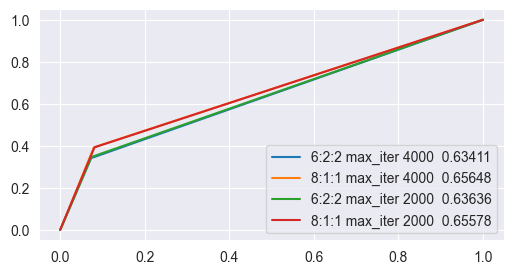

In [93]:
plt.figure(figsize=(6, 3))
plt.plot(fpr0, tpr0, label="6:2:2 max_iter 4000  " + "{:.5f}".format(auc0))
plt.plot(fpr1, tpr1, label="8:1:1 max_iter 4000  " + "{:.5f}".format(auc1))
plt.plot(fpr2, tpr2, label="6:2:2 max_iter 2000  " + "{:.5f}".format(auc2))
plt.plot(fpr3, tpr3, label="8:1:1 max_iter 2000  " + "{:.5f}".format(auc3))
plt.legend(loc=4)
plt.show()

It seems that there is no significant difference between max iteration 4000 and 2000

Text(0, 0.5, 'Accuracy')

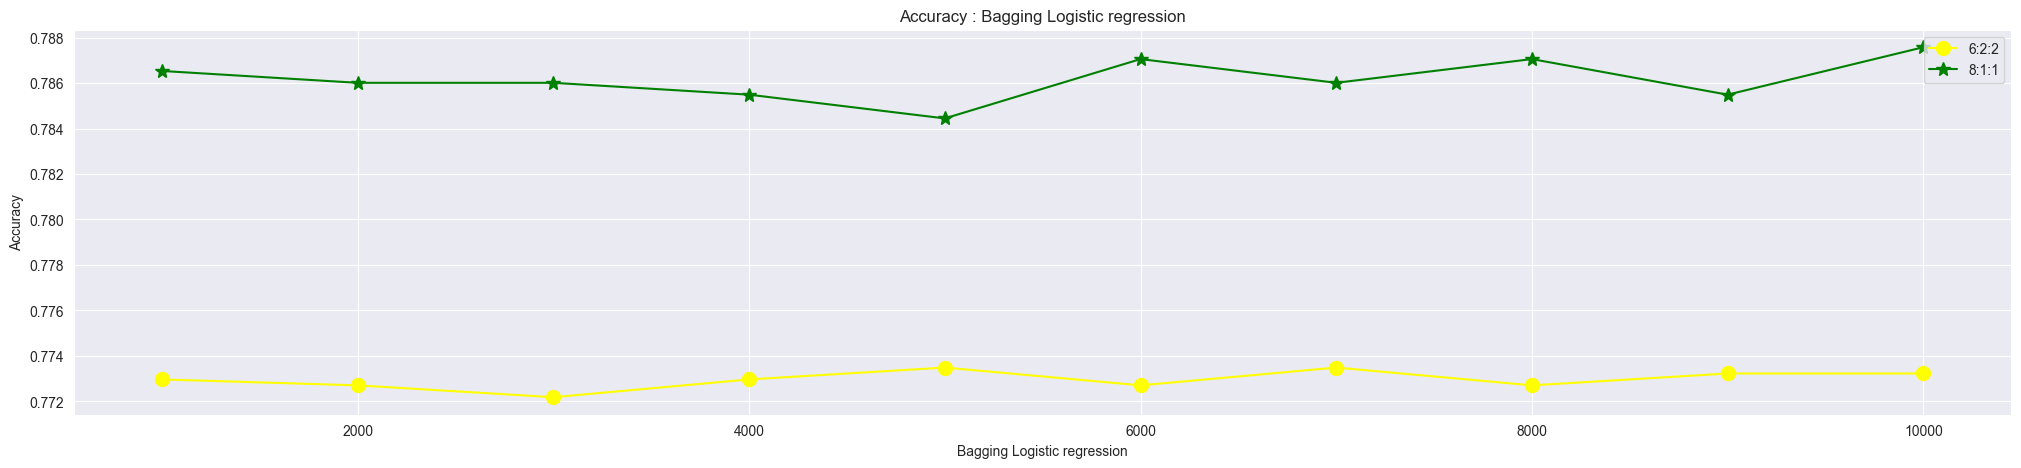

In [94]:
accuracy_bl_1 = []
accuracy_bl_2 = []
for i in range(1, 11):
    classifier = LogisticRegression(max_iter=i * 1000)
    bag = BaggingClassifier(estimator=base_log_reg, n_estimators=10)
    bag.fit(x_train_1, y_train_1)
    y_pred = bag.predict(x_validation_1)
    acc = metrics.accuracy_score(y_validation_1, y_pred)
    accuracy_bl_1.append(acc)

for i in range(1, 11):
    classifier = LogisticRegression(max_iter=i * 1000)
    bag = BaggingClassifier(estimator=base_log_reg, n_estimators=10)
    bag.fit(x_train_2, y_train_2)
    y_pred = bag.predict(x_validation_2)
    acc = metrics.accuracy_score(y_validation_2, y_pred)
    accuracy_bl_2.append(acc)

plt.figure(figsize=(25, 5))
plt.plot(range(1000, 11000, 1000), accuracy_bl_1, color='yellow', marker='o', markersize=10, label="6:2:2")
plt.plot(range(1000, 11000, 1000), accuracy_bl_2, color='green', marker='*', markersize=10, label="8:1:1")
plt.legend()

plt.title('Accuracy : Bagging Logistic regression')
plt.xlabel('Bagging Logistic regression')
plt.ylabel('Accuracy')

It is clear the 6:2:2 has better performance and iteration 8000 has the best performance

## 5. Random Forest
Random Forest is a powerful ensemble learning algorithm widely used in machine learning. It constructs multiple decision trees during training and merges their predictions to improve accuracy and mitigate overfitting. By introducing randomness in the tree-building process, such as feature selection and bootstrapped samples, Random Forest enhances robustness and generalization. This algorithm is effective for classification and regression tasks, handling large datasets and high-dimensional features. Its versatility, efficiency, and resistance to overfitting make Random Forest a popular choice in various domains, ensuring reliable and accurate predictions.

In [95]:
print('Random Forest 6:2:2')
print('\nMax_depth = 5')

random = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=12345)
random.fit(x_train_1, y_train_1)
y_pred0 = random.predict(x_validation_1)
accuracy_random_forest = []
f1_random_forest = []
acc0 = metrics.accuracy_score(y_validation_1, y_pred0)
accuracy_random_forest.append(acc0)
f1_score = metrics.f1_score(y_validation_1, y_pred0)
f1_random_forest.append(f1_score)
print("Accuracy: ", acc0)
print(metrics.classification_report(y_pred=y_pred0, y_true=y_validation_1))
auc0 = metrics.roc_auc_score(y_validation_1, y_pred0)
fpr0, tpr0, _ = metrics.roc_curve(y_validation_1, y_pred0)
print("----------------------------------------------------")
print('\nMax_depth = 25')

random = RandomForestClassifier(n_estimators=200, max_depth=25, random_state=12345)
random.fit(x_train_1, y_train_1)
y_pred1 = random.predict(x_validation_1)
acc1 = metrics.accuracy_score(y_validation_1, y_pred1)
accuracy_random_forest.append(acc1)
f1_score = metrics.f1_score(y_validation_1, y_pred1)
f1_random_forest.append(f1_score)
print("Accuracy: ", acc1)
print(metrics.classification_report(y_pred=y_pred1, y_true=y_validation_1))
auc1 = metrics.roc_auc_score(y_validation_1, y_pred1)
fpr1, tpr1, _ = metrics.roc_curve(y_validation_1, y_pred1)

print("～～～～～～～～～～～～～～～～～～～～～～～～～～～～～～～～")
print("～～～～～～～～～～～～～～～～～～～～～～～～～～～～～～～～")
print('\n\nRandom Forest 8:1:1')
print('\nMax_depth = 5')

random = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=12345)
random.fit(x_train_2, y_train_2)
y_pred2 = random.predict(x_validation_2)
acc2 = metrics.accuracy_score(y_validation_2, y_pred2)
accuracy_random_forest.append(acc2)
f1_score = metrics.f1_score(y_validation_2, y_pred2)
f1_random_forest.append(f1_score)
print("Accuracy: ", acc2)
print(metrics.classification_report(y_pred=y_pred2, y_true=y_validation_2))
auc2 = metrics.roc_auc_score(y_validation_2, y_pred2)
fpr2, tpr2, _ = metrics.roc_curve(y_validation_2, y_pred2)

print("----------------------------------------------------")
print('\nMax_depth = 25')

random = RandomForestClassifier(n_estimators=200, max_depth=25, random_state=12345)
random.fit(x_train_2, y_train_2)
y_pred3 = random.predict(x_validation_2)
acc3 = metrics.accuracy_score(y_validation_2, y_pred3)
accuracy_random_forest.append(acc3)
f1_score = metrics.f1_score(y_validation_2, y_pred3)
f1_random_forest.append(f1_score)
print("Accuracy: ", acc3)
print(metrics.classification_report(y_pred=y_pred3, y_true=y_validation_2))
auc3 = metrics.roc_auc_score(y_validation_2, y_pred3)
fpr3, tpr3, _ = metrics.roc_curve(y_validation_2, y_pred3)

acc_rf = sum(accuracy_random_forest) / 4
f1_rf = sum(f1_random_forest) / 4
accuracy_ave.append(acc_rf)
f1_ave.append(f1_rf)
models.append('Random Forest')
print("The average of Random Forest accuracy is:", acc_rf)
print("The average of Random Forest f1 score is:", f1_rf)

Random Forest 6:2:2

Max_depth = 5
Accuracy:  0.7750521920668059
              precision    recall  f1-score   support

           0       0.80      0.93      0.86      2820
           1       0.63      0.35      0.45      1012

    accuracy                           0.78      3832
   macro avg       0.72      0.64      0.65      3832
weighted avg       0.76      0.78      0.75      3832

----------------------------------------------------

Max_depth = 25
Accuracy:  0.7539144050104384
              precision    recall  f1-score   support

           0       0.79      0.90      0.84      2820
           1       0.55      0.35      0.43      1012

    accuracy                           0.75      3832
   macro avg       0.67      0.62      0.64      3832
weighted avg       0.73      0.75      0.73      3832

～～～～～～～～～～～～～～～～～～～～～～～～～～～～～～～～
～～～～～～～～～～～～～～～～～～～～～～～～～～～～～～～～


Random Forest 8:1:1

Max_depth = 5
Accuracy:  0.7839248434237995
              precision    recall  f1-score   sup

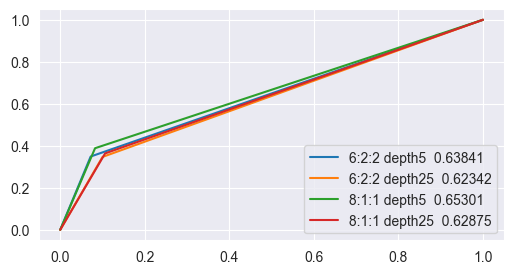

In [96]:
plt.figure(figsize=(6, 3))
plt.plot(fpr0, tpr0, label="6:2:2 depth5  " + "{:.5f}".format(auc0))
plt.plot(fpr1, tpr1, label="6:2:2 depth25  " + "{:.5f}".format(auc1))
plt.plot(fpr2, tpr2, label="8:1:1 depth5  " + "{:.5f}".format(auc2))
plt.plot(fpr3, tpr3, label="8:1:1 depth25  " + "{:.5f}".format(auc3))
plt.legend(loc=4)
plt.show()

Text(0, 0.5, 'Accuracy')

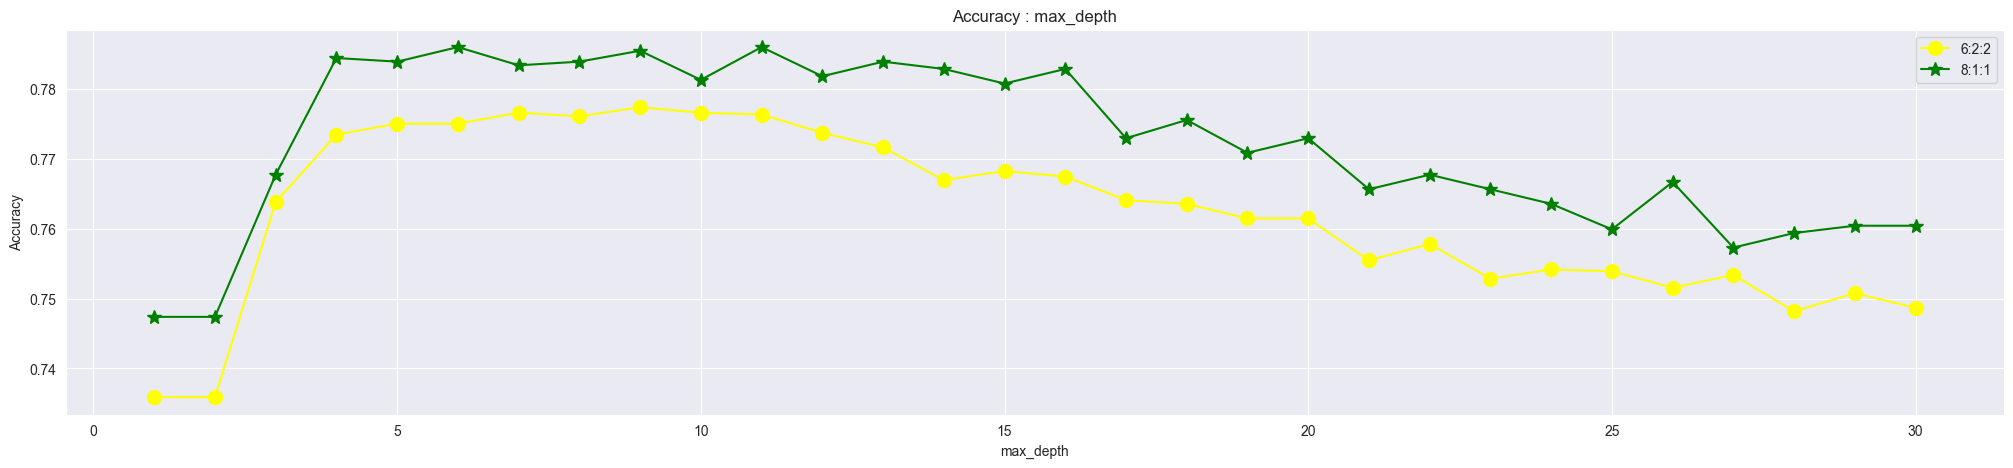

In [97]:
accuracy_1 = []
for i in range(1, 31):
    rf = RandomForestClassifier(n_estimators=200, max_depth=i, random_state=12345)
    rf.fit(x_train_1, y_train_1)
    pred_i = rf.predict(x_validation_1)
    acc = metrics.accuracy_score(y_validation_1, pred_i)
    accuracy_1.append(acc)

accuracy_2 = []
for i in range(1, 31):
    rf = RandomForestClassifier(n_estimators=200, max_depth=i, random_state=12345)
    rf.fit(x_train_2, y_train_2)
    pred_i = rf.predict(x_validation_2)
    acc = metrics.accuracy_score(y_validation_2, pred_i)
    accuracy_2.append(acc)

plt.figure(figsize=(25, 5))
plt.plot(range(1, 31), accuracy_1, color='yellow', marker='o', markersize=10, label="6:2:2")
plt.plot(range(1, 31), accuracy_2, color='green', marker='*', markersize=10, label="8:1:1")
plt.legend()

plt.title('Accuracy : max_depth')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

With the increase in maxlength, the performance initially improves, reaching its peak between 5 and 15, and then gradually declines. Model with max_depth 7 has the best performance.

## 6. Voting

In this part I combine the knn, random forest and decision tree, try two kind of dataset division. The variables are selected based on the best-performing parameters obtained from previous experiments.

In [98]:
knn_model = KNeighborsClassifier(n_neighbors=43)
decision_model = DecisionTreeClassifier(max_depth=5)
randf_model = RandomForestClassifier(n_estimators=200, max_depth=7, random_state=12345)

voting_model = VotingClassifier(
    estimators=[('knn', knn_model), ('decision', decision_model), ('RandForest', randf_model)],
    voting='soft')
accuracy_voting = []
f1_voting = []
print("Voting 6:2:2")
voting_model.fit(x_train_1, y_train_1)
pred_1 = voting_model.predict(x_validation_1)
acc_1 = metrics.accuracy_score(y_validation_1, pred_1)
accuracy_voting.append(acc_1)
f1_score = metrics.f1_score(y_validation_1, pred_1)
f1_voting.append(f1_score)
print("Accuracy: ", acc_1)
print(metrics.classification_report(y_pred=pred_1, y_true=y_validation_1))
auc_1 = metrics.roc_auc_score(y_validation_1, pred_1)
fpr_1, tpr_1, _ = metrics.roc_curve(y_validation_1, pred_1)

print("Voting 8:1:1")
voting_model.fit(x_train_2, y_train_2)
pred_2 = voting_model.predict(x_validation_2)
acc_2 = metrics.accuracy_score(y_validation_2, pred_2)
accuracy_voting.append(acc_2)
f1_score = metrics.f1_score(y_validation_2, pred_2)
f1_voting.append(f1_score)
print("Accuracy: ", acc_2)
print(metrics.classification_report(y_pred=pred_2, y_true=y_validation_2))
auc_2 = metrics.roc_auc_score(y_validation_2, pred_2)
fpr_2, tpr_2, _ = metrics.roc_curve(y_validation_2, pred_2)
acc_voting = sum(accuracy_voting) / 2  # store the average number of accuracy of voting
accuracy_ave.append(acc_voting)
f1_v = sum(f1_voting) / 2
f1_ave.append(f1_v)
models.append('Voting')
print("The average of Voting accuracy is:", acc_voting)
print("The average of Voting f1 score is:", f1_v)

Voting 6:2:2
Accuracy:  0.7779227557411273
              precision    recall  f1-score   support

           0       0.81      0.92      0.86      2820
           1       0.63      0.39      0.48      1012

    accuracy                           0.78      3832
   macro avg       0.72      0.65      0.67      3832
weighted avg       0.76      0.78      0.76      3832

Voting 8:1:1
Accuracy:  0.7813152400835073
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1432
           1       0.59      0.42      0.49       484

    accuracy                           0.78      1916
   macro avg       0.71      0.66      0.68      1916
weighted avg       0.76      0.78      0.77      1916

The average of Voting accuracy is: 0.7796189979123174
The average of Voting f1 score is: 0.48735919143627493


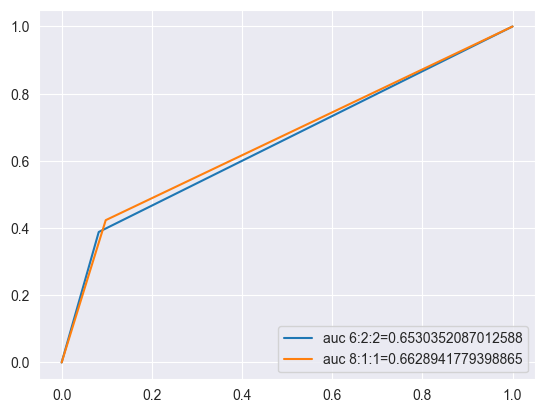

In [99]:
plt.plot(fpr_1, tpr_1, label="auc 6:2:2=" + str(auc_1))
plt.plot(fpr_2, tpr_2, label="auc 8:1:1=" + str(auc_2))
plt.legend(loc=4)
plt.show()

# Step 5: Conclusion

[0.7768462943632568, 0.7738778705636744, 0.7467379958246346, 0.7796189979123174, 0.7682019832985386, 0.7796189979123174]
Model:  Decision Tree  Accuracy:  0.7768462943632568
Model:  KNN  Accuracy:  0.7738778705636744
Model:  Naive Bayes  Accuracy:  0.7467379958246346
Model:  Bagging Logistic regression  Accuracy:  0.7796189979123174
Model:  Random Forest  Accuracy:  0.7682019832985386
Model:  Voting  Accuracy:  0.7796189979123174


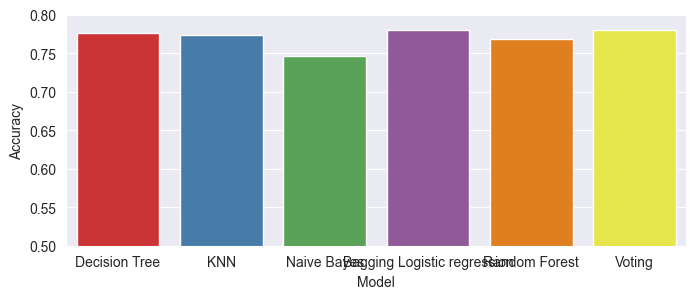

In [100]:
data_acc = pd.DataFrame({'Model': models, 'Accuracy': accuracy_ave})
print(accuracy_ave)
plt.figure(figsize=(8, 3))
colors = sns.color_palette("Set1", len(models))
bar = sns.barplot(x='Model', y='Accuracy', data=data_acc, palette=colors, legend=False, hue=models)
bar.set_ylim(0.5, 0.8)
for i in range(len(models)):
    print("Model: ", models[i], " Accuracy: ", accuracy_ave[i])

[0.4860081831253553, 0.4550324364830392, 0.506062198012012, 0.46288810087410437, 0.44661243160999453, 0.48735919143627493]
Model:  Decision Tree  F1 score:  0.4860081831253553
Model:  KNN  F1 score:  0.4550324364830392
Model:  Naive Bayes  F1 score:  0.506062198012012
Model:  Bagging Logistic regression  F1 score:  0.46288810087410437
Model:  Random Forest  F1 score:  0.44661243160999453
Model:  Voting  F1 score:  0.48735919143627493


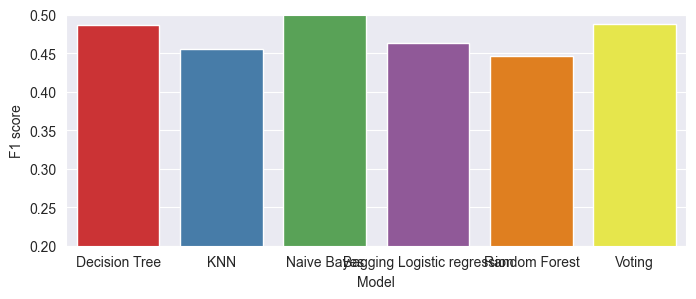

In [101]:
data_f1 = pd.DataFrame({'Model': models, 'F1 score': f1_ave})
print(f1_ave)
plt.figure(figsize=(8, 3))
colors = sns.color_palette("Set1", len(models))
bar = sns.barplot(x='Model', y='F1 score', data=data_f1, palette=colors, legend=False, hue=models)
bar.set_ylim(0.2, 0.5)
for i in range(len(models)):
    print("Model: ", models[i], " F1 score: ", f1_ave[i])
plt.show()

It is clear that except the Naive Bayes, other model has the similar accuracy. Decision Tree, Voting and Naive Bayes get higher score in f1 evaluation.

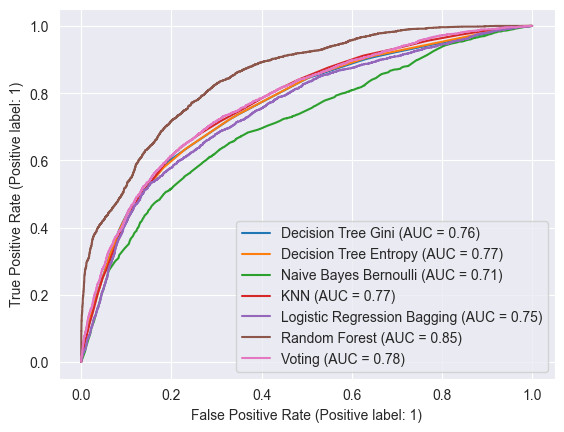

In [102]:
ax = plt.gca()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4)
x_test, x_validation, y_test, y_validation = train_test_split(x_test, y_test, test_size=0.5)
# gini and entropy have the similar performance, and the max_depth 6 is greatest
dt_cross_gini = DecisionTreeClassifier(criterion='gini', max_depth=6)
dt_cross_gini.fit(x_train, y_train)
plot_dt_gini = RocCurveDisplay.from_estimator(estimator=dt_cross_gini, X=x_train, y=y_train, ax=ax,
                                              name='Decision Tree Gini')
dt_cross_entropy = DecisionTreeClassifier(criterion='entropy', max_depth=6)
dt_cross_entropy.fit(x_train, y_train)
plot_dt_entropy = RocCurveDisplay.from_estimator(estimator=dt_cross_entropy, X=x_train, y=y_train, ax=ax,
                                                 name='Decision Tree Entropy')
# Bernoulli is better than Gaussian
nb_cross = BernoulliNB()
nb_cross.fit(x_train, y_train)
plot_nb = RocCurveDisplay.from_estimator(estimator=nb_cross, X=x_train, y=y_train, ax=ax, name='Naive Bayes Bernoulli')
# knn with 20 n_neighbors is better
knn_cross = KNeighborsClassifier(n_neighbors=57)
knn_cross.fit(x_train, y_train)
plot_knn = RocCurveDisplay.from_estimator(estimator=knn_cross, X=x_train, y=y_train, ax=ax, name='KNN')
# Logistic Regression with 2000 max_iter is better
bag_cross = LogisticRegression(max_iter=2000)
bag_cross.fit(x_train, y_train)
plot_bag = RocCurveDisplay.from_estimator(estimator=bag_cross, X=x_train, y=y_train, ax=ax,
                                          name='Logistic Regression Bagging')
# RandomForest with 13 max_depth and 200 n_estimators is better
rf_cross = RandomForestClassifier(max_depth=10, n_estimators=200)
rf_cross.fit(x_train, y_train)
plot_rf = RocCurveDisplay.from_estimator(estimator=rf_cross, X=x_train, y=y_train, ax=ax, name='Random Forest')
# voting_clf is trained in 6.6 part
plot_vt = RocCurveDisplay.from_estimator(estimator=voting_model, X=x_train, y=y_train, ax=ax, name='Voting')

From this Graph, Random Forest and Voting have the highest grade. Naive bayes get the lowest score. Hence, in the model training, we might have the Voting as the final model because it has the great performance in every evaluation.